# Specificity bar charts

This notebook generates bar charts illustrating the specificity of ASVs to different host groups, a la [Figure 4](https://github.com/biocore/emp/blob/master/methods/images/figure4_entropy.png) from the [Earth Microbiome Project paper](http://doi.org/10.1038/nature24621). It is a rewrite of [the code used](https://github.com/biocore/emp/tree/master/code/09-specificity-entropy) to generate that figure. 

## Imports and functions

In [1]:
import biom
import pandas as pd
import numpy as np
import time

import matplotlib as mpl
from matplotlib import cm
import seaborn as sns
from matplotlib import pyplot as plt
from os import makedirs
from os.path import join

# for ordering
from scipy import cluster,spatial,stats 
import skbio.diversity.alpha
from pandas.api.types import CategoricalDtype

# qiime
from biom import Table
from qiime2 import Artifact

# plotting
from plotnine import *

np.random.seed(2016)

### Function: `make_env_table`

This function summarizes each entry in an OTU table by the number of times in which it occurs in samples from each environment.

In [2]:
test_ids = ['o0', 'o1', 'o2', 'o3']
test_samp = ['A', 'B', 'C']
test_data = np.array([[0, 0, 1],
             [0, 1, 0],
             [1, 1, 1],
             [1, 1, 0]])

             
test_otu = biom.Table(test_data, test_ids, test_samp)

test_md = pd.DataFrame({'SampleID': ['A', 'B', 'C'],
                        'env': ['foo', 'foo', 'bar']}).set_index('SampleID')

exp_env = pd.DataFrame({'foo': [0.,1.,2.,2.],
                        'bar': [1.,0.,1.,0.]},
                       index = test_ids)

def make_env_table(otu_table, md, env_field):
    '''
    This function summarizes each entry in an OTU table by the number
    of times in which it occurs in samples from each environment.
    
    Parameters
    ----------
    otu_table : biom.Table
        The (filtered) OTU table
    md : pd.DataFrame
        The metadata containing environment information for samples
        in `otu_table`, with md.index corresponding to the OTU table
        ids.
    env_field : str
        The column name in `md` containing the environment categories
        that will define the env table columns
        
    Returns
    -------
    pd.DataFrame
        The environment table, with index corresponding to the input
        biom observation ids, and columns corresponding to the unique
        values of `md[env_field]`.
    '''
    value_counts = {}
    sample_md = md.loc[otu_table.ids(axis='sample')]

    for otu in otu_table.ids(axis='observation'):
        otu_freq = otu_table.data(otu, axis='observation', dense=True)
        value_counts[otu] = sample_md.loc[otu_freq != 0, env_field].value_counts()
    
    env_table = pd.DataFrame.from_dict(value_counts, orient='index').fillna(value=0)
    
    return(env_table)


obs_env = make_env_table(test_otu, test_md, 'env')

pd.testing.assert_frame_equal(obs_env, exp_env, check_like = True)

### Function: `plot_tax_env`

This function summarizes each entry in an OTU table by the number of times in which it occurs in samples from each environment.

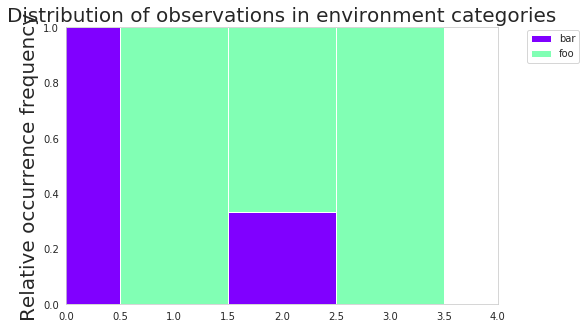

In [3]:
def plot_tax_env(env_table, 
               reorder=False,
               xlabels=None,
               num_otu=None,
               env_colors=None,
               env_cmap=cm.rainbow,
               wide=False):
    '''Plot the environment distribution bar charts.
    
    Akin to a taxonomy bar chart, except that each bar indicates a different 
    OTU or ASV, while the stacked bars correspond to the proportion of samples
    from each environment in which that ASV is found. For example, if OTU 1 is
    found in 1 sample from environment A and 2 samples from environment B, the
    bar for OTU 1 will be 1/3 environment A and 2/3 environment B. 

    Parameters
    ----------
    env_table : pd.DataFrame
        key is taxonomy or otuid, value is np-array of weighted freq. of each
        environmental category
    reorder : bool
        True to reorder the taxonomy based on clustering of empo_3 freq.
    xlabels : dict of str or None
        None to hide x labels, otherwise dict of row: value pairs to plot
    num_otu : int or None
        if None, use all taxonomies/otus
        if int, randomly keep only int otus to display (useful when displaying
        the otu level)
    env_colors : dict of str or None
        Dict of color labels to assign environments; none to choose from
        `env_colormap`.
    env_cmap : mpl.colormap object
        Colormap from which to choose environment colors (Default = cm.rainbow)
    wide : bool
        True to force a 20x9 aspect ratio
    
    Returns
    -------
        a handle for the figure generated
    '''

    np.random.seed(2016)

    # Convert to relative abundance
    env_table = env_table.div(env_table.sum(axis=1), axis=0).fillna(0)
    
    if num_otu is not None:
        # randomly take a subset of the entries (sublist)
        use_table = env_table.sample(n=num_otu)
    else:
        use_table = env_table.copy()


    if reorder:
        # re-order bacterial taxonomy groups according to euclidean distance
        dm = spatial.distance.pdist(use_table, metric='euclidean')
        clust = cluster.hierarchy.single(dm)
        order = cluster.hierarchy.leaves_list(clust)

        use_table = use_table.iloc[order]

    if env_colors is None:
        norm = mpl.colors.Normalize(vmin=0, vmax=len(env_table.columns))

        env_colors = {}
        for i, env in enumerate(env_table.columns):
            env_colors[env] = cm.ScalarMappable(norm=norm,
                                                cmap=env_cmap).to_rgba(i)

    cols = np.arange(len(use_table.index))
    sns.set_style('whitegrid', {'axes.grid': False})

    if wide:
        fig = plt.figure(figsize=(20, 9))
    else:
        fig = plt.figure()

    # [ax1_x, ax1_y, ax1_w, ax1_h] = [0.0, 0.0, 1.0, 0.03]
    [axm_x, axm_y, axm_w, axm_h] = [0.0, 0.06, 1.0, 0.96]
    # [axc_x, axc_y, axc_w, axc_h] = [1.01, 0.0, 0.03, 0.48]

    axm = fig.add_axes([axm_x, axm_y, axm_w, axm_h], frame_on=True)

    # looping through all the environments
    for i in range(len(use_table.columns)):
        env = use_table.columns[i]

        # the bottom of each environment bar should be the cumulative sum
        # of all preceding environments
        bottom = use_table.iloc[:, 0:i].sum(axis=1)
        height = use_table.iloc[:, i]

        if xlabels is not None:
            axm.bar(cols, height, width=0.5, bottom=bottom,
                    color=env_colors[env], edgecolor=None, label=env)
        else:
            axm.bar(cols, height, width=1, bottom=bottom,
                    color=env_colors[env], edgecolor=None, label=env)
        

    plt.ylabel("Relative occurrence frequency", fontsize=20)
    plt.ylim([0, 1])
    plt.title("Distribution of observations in environment categories",
              fontsize=20)
    plt.legend(bbox_to_anchor=(1.2, 1.01))

    # plot x labels
    if xlabels is not None:
        xticks = [xlabels[y] for y in use_table.rows]
        fig = plt.xticks(cols+0.25, xticks, rotation='vertical', fontsize=16)
    plt.xlim(0, len(cols))

    return(fig)

a = plot_tax_env(obs_env)

# Test distributions

## Everything

In [4]:
# load biom table
table_fp = '../tables/filtered/merged-table.in-map.nomito-nochloro.10k.qza'
table_art = Artifact.load(table_fp)
table = table_art.view(Table)

In [5]:
# load mapping file
md_fp = '../metadata/eco_md-qiime_host_species_eco_metadata_by_SampleID_gut_2.18.19.txt'
md = pd.read_table(md_fp, sep="\t")
md = md.set_index("SampleID")
md = md.loc[table.ids(axis='sample')]

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (34,35,83,168) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# load taxonomy
tax_fp = '../taxonomy/sepp.taxonomy.qza'
tax_art = Artifact.load(tax_fp)
tax = tax_art.view(pd.DataFrame)

In [7]:
# create figures directory
fig_dir = '../specificity_barcharts'

makedirs(fig_dir,  exist_ok=True)

### Settings

In [8]:
# colormap
cmap = cm.gist_ncar
num_otus = 400

## All classes

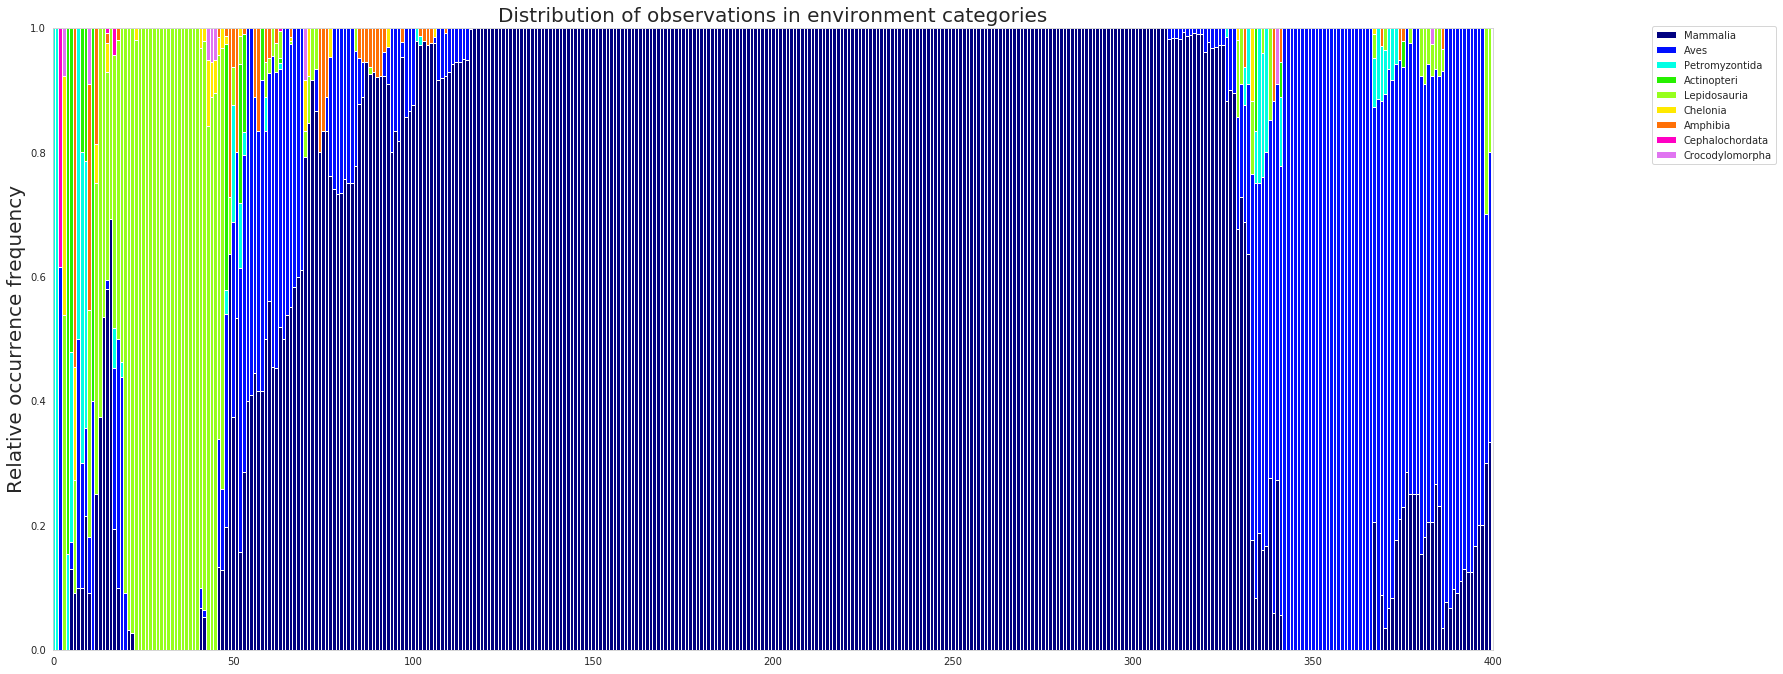

In [9]:
map_field_name = 'Taxonomy_Class'

vert_table = table.filter(md.loc[md['Taxonomy_Phylum'] == 'Chordata'].index,
                            axis='sample', inplace=False)

vert_table.filter(lambda val, id_, md: (val > 0).sum() >= 10,
                    axis='observation',
                    inplace=True)

vert_env = make_env_table(vert_table,
                          md,
                          map_field_name)

fig = plot_tax_env(vert_env,
                   reorder=True,
                   xlabels=None, 
                   num_otu=num_otus,
                   env_colors=None, 
                   env_cmap=cmap,
                   wide=True)

fig.savefig(join(fig_dir, 'vert_otu.class.pdf'),
            bbox_inches='tight')

## Mammals

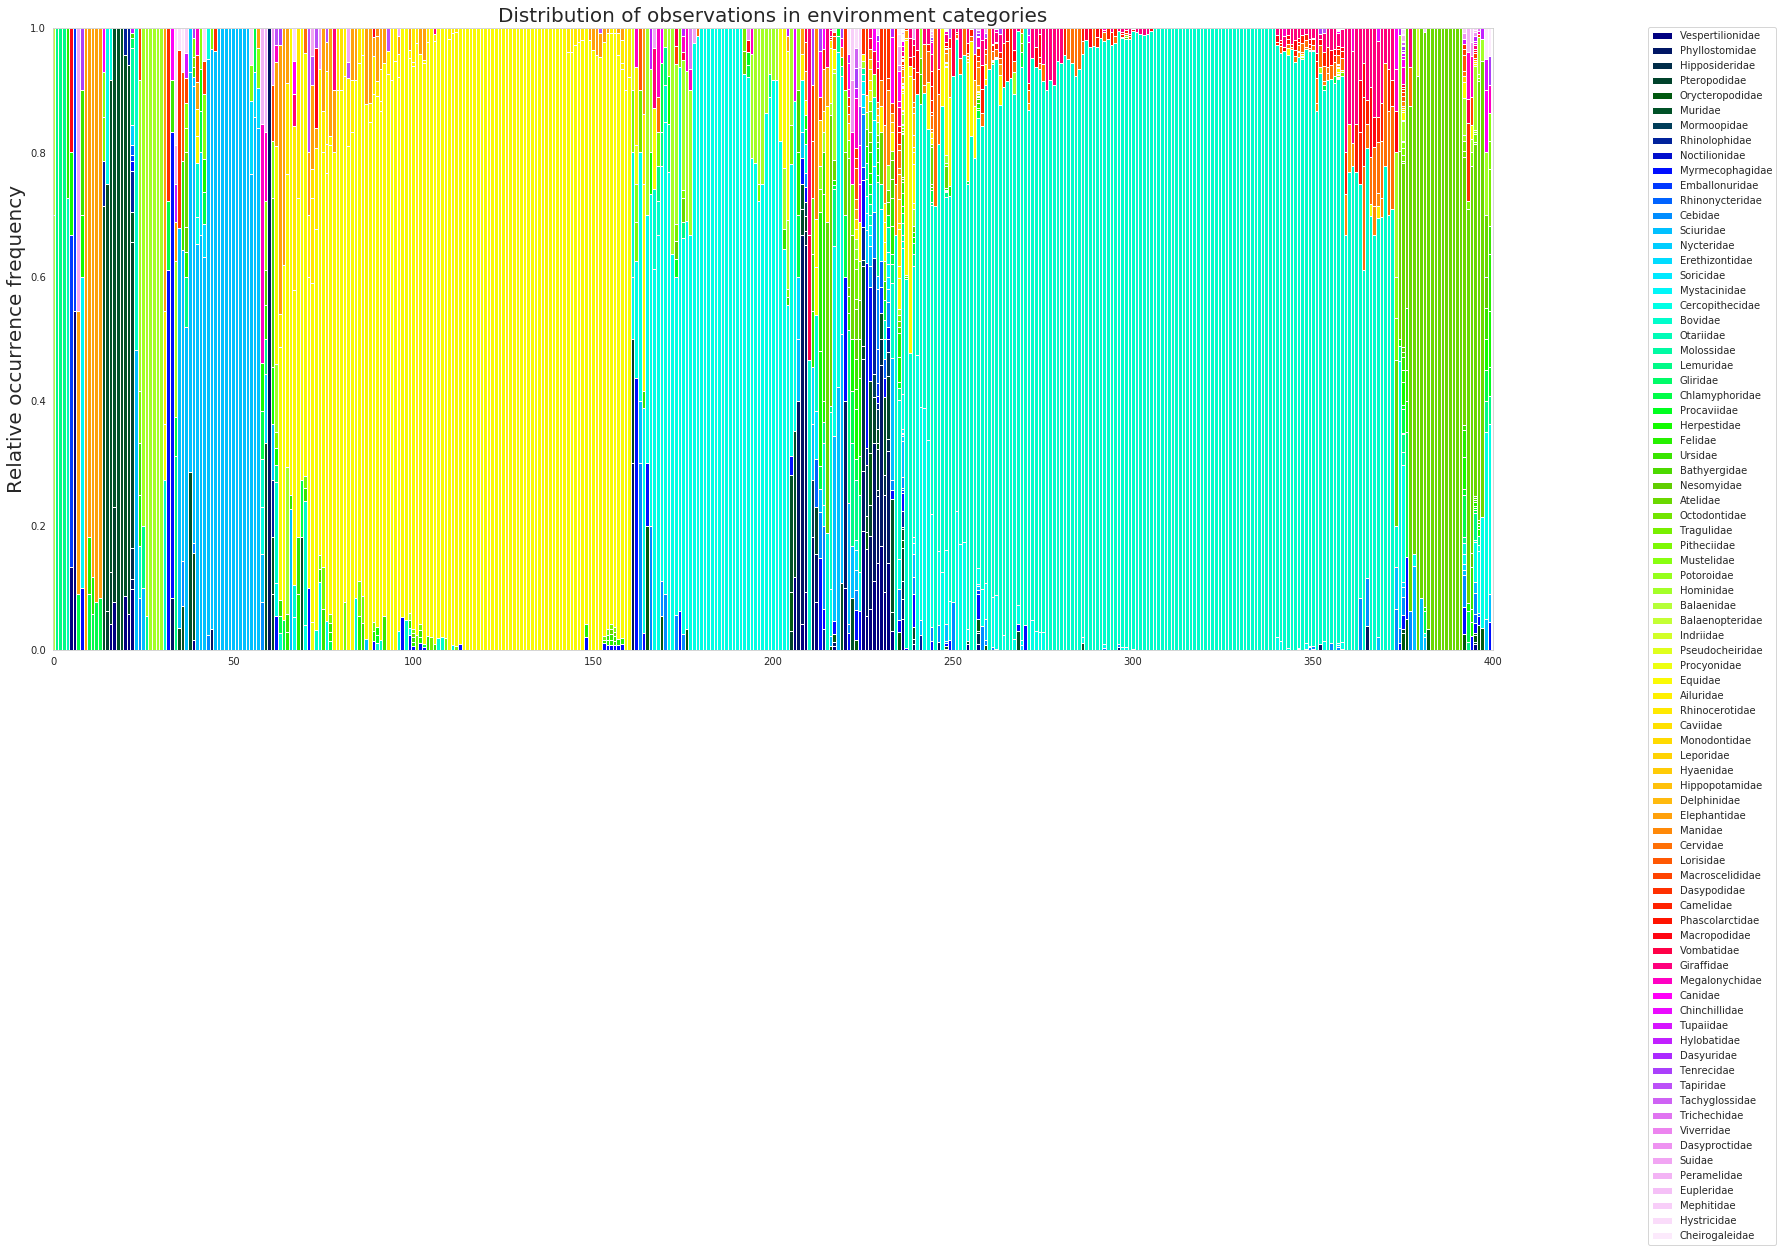

In [10]:
map_field_name = 'Taxonomy_Family'

mammal_table = table.filter(md.loc[md['Taxonomy_Class'] == 'Mammalia'].index,
                            axis='sample', inplace=False)

mammal_table.filter(lambda val, id_, md: (val > 0).sum() >= 10,
                    axis='observation',
                    inplace=True)

mammal_otu = make_env_table(mammal_table,
                            md,
                            map_field_name)

# mammal_otu_rel = mammal_otu.div(mammal_otu.sum(axis=1), axis=0).fillna(0)

fig = plot_tax_env(mammal_otu,
                   reorder=True,
                   xlabels=None, 
                   num_otu=num_otus,
                   env_colors=None, 
                   env_cmap=cmap,
                   wide=True)

fig.savefig(join(fig_dir, 'mammal_otu.family.pdf'),
            bbox_inches='tight')

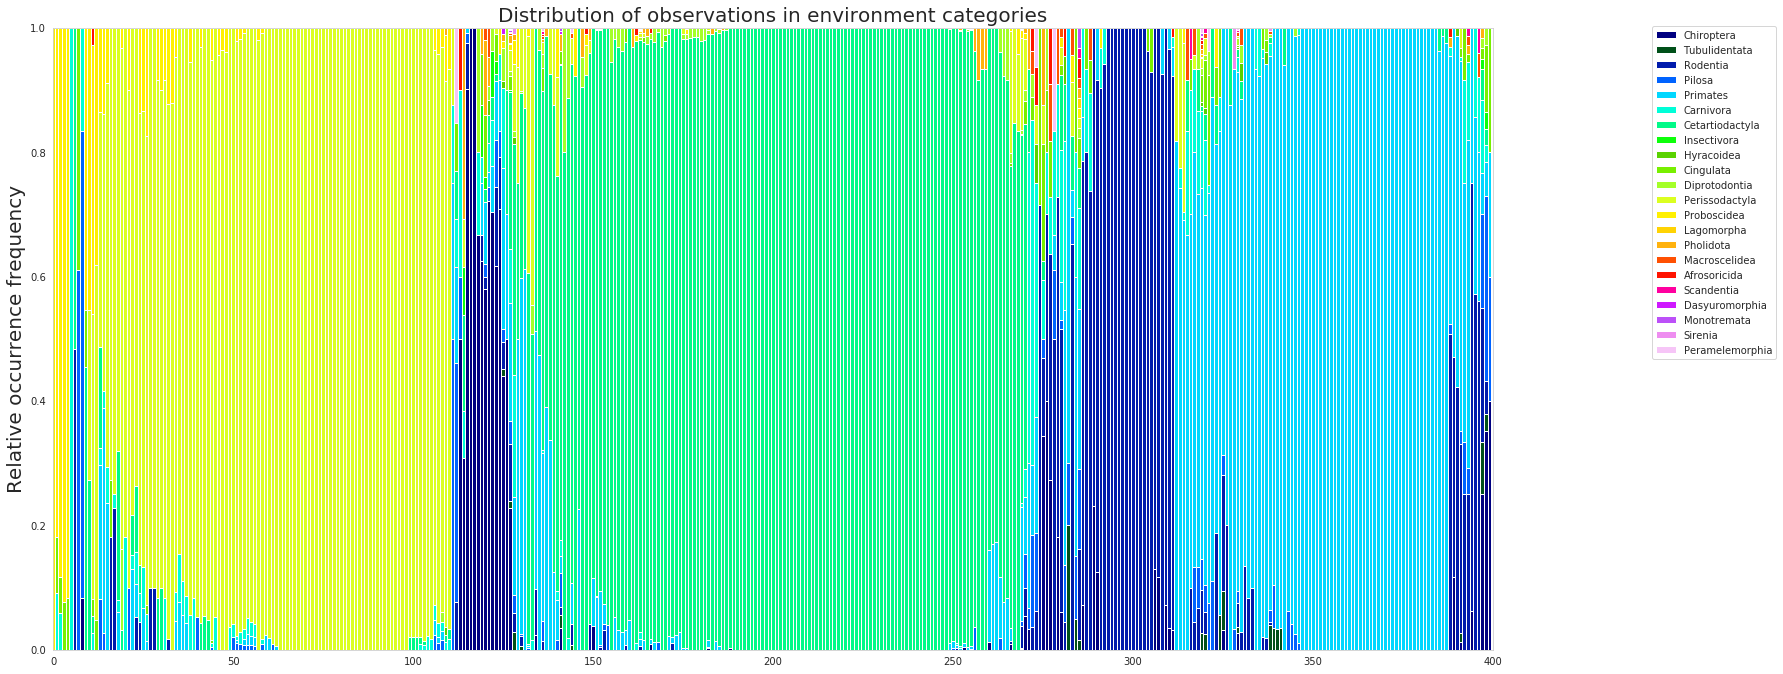

In [11]:
map_field_name = 'Taxonomy_Order'

mammal_table = table.filter(md.loc[md['Taxonomy_Class'] == 'Mammalia'].index,
                            axis='sample', inplace=False)

mammal_table.filter(lambda val, id_, md: (val > 0).sum() >= 10,
                    axis='observation',
                    inplace=True)

mammal_otu = make_env_table(mammal_table,
                            md,
                            map_field_name)

fig = plot_tax_env(mammal_otu,
                   reorder=True,
                   xlabels=None,
                   num_otu=num_otus,
                   env_colors=None, 
                   env_cmap=cmap,
                   wide=True)

fig.savefig(join(fig_dir, 'mammal_otu.order.pdf'),
            bbox_inches='tight')

### Bats

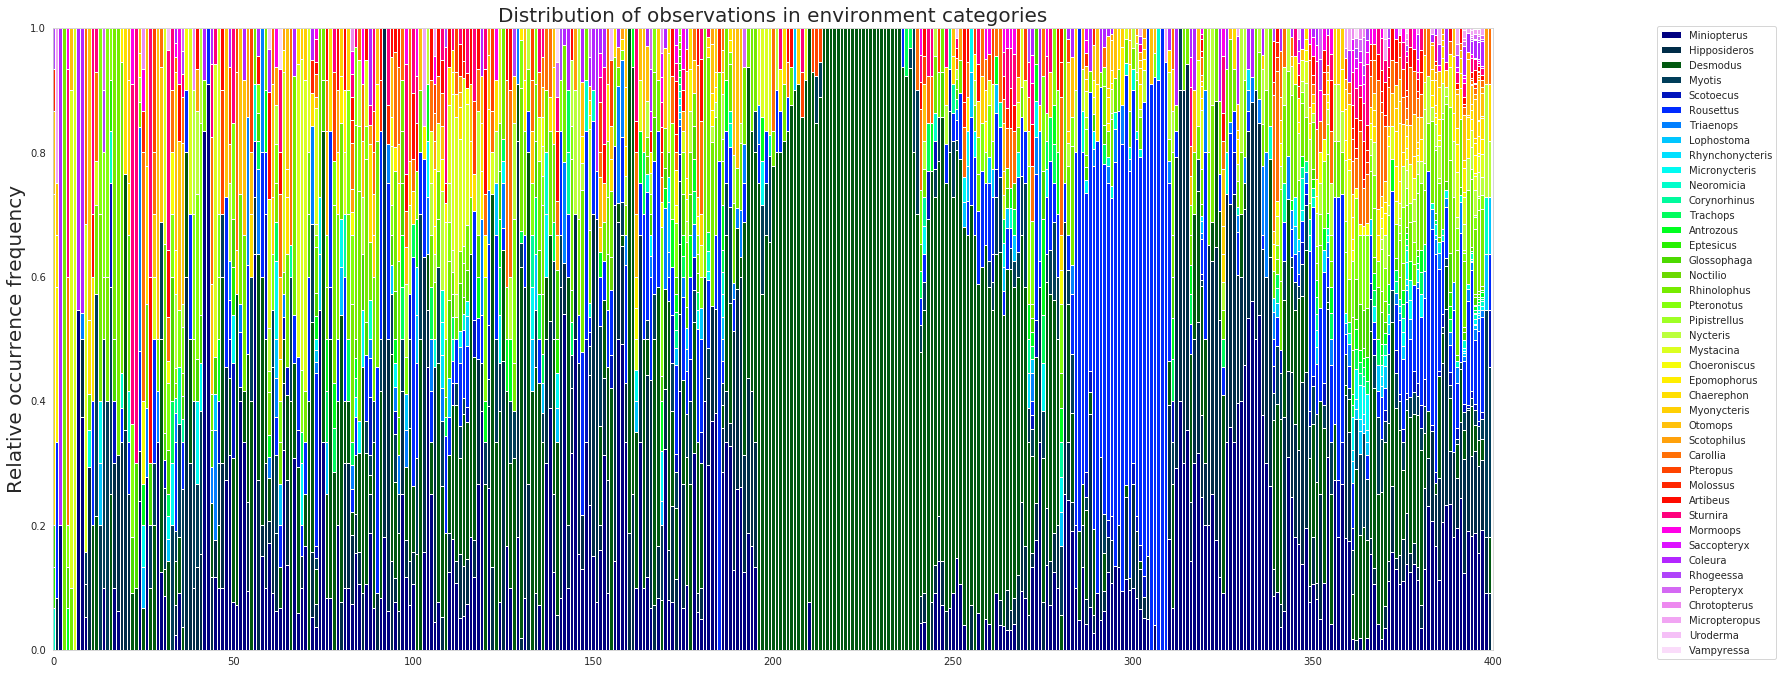

In [12]:
map_field_name = 'Taxonomy_Genus'

mammal_table = table.filter(md.loc[md['Taxonomy_Order'] == 'Chiroptera'].index,
                            axis='sample', inplace=False)

mammal_table.filter(lambda val, id_, md: (val > 0).sum() >= 10,
                    axis='observation',
                    inplace=True)

mammal_otu = make_env_table(mammal_table,
                            md,
                            map_field_name)

fig = plot_tax_env(mammal_otu,
                   reorder=True,
                   xlabels=None, 
                   num_otu=num_otus,
                   env_colors=None, 
                   env_cmap=cmap,
                   wide=True)

fig.savefig(join(fig_dir, 'bat_otu.genus.pdf'),
            bbox_inches='tight')

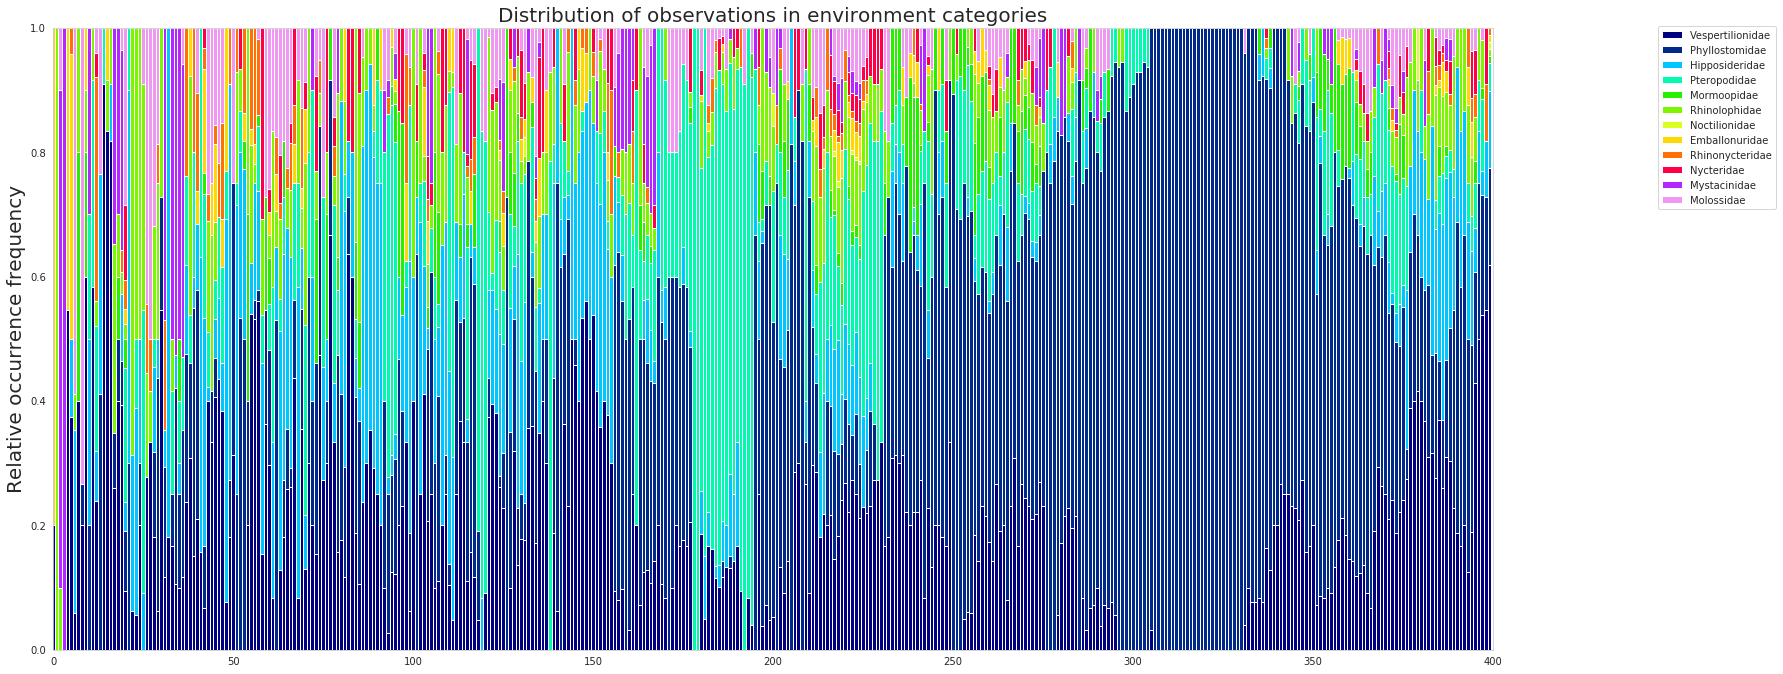

In [13]:
map_field_name = 'Taxonomy_Family'

mammal_table = table.filter(md.loc[md['Taxonomy_Order'] == 'Chiroptera'].index,
                            axis='sample', inplace=False)

mammal_table.filter(lambda val, id_, md: (val > 0).sum() >= 10,
                    axis='observation',
                    inplace=True)

mammal_otu = make_env_table(mammal_table,
                            md,
                            map_field_name)

fig = plot_tax_env(mammal_otu,
                   reorder=True,
                   xlabels=None, 
                   num_otu=num_otus,
                   env_colors=None, 
                   env_cmap=cmap,
                   wide=True)


fig.savefig(join(fig_dir, 'bat_otu.family.pdf'),
            bbox_inches='tight')

### Cetartiodactyla

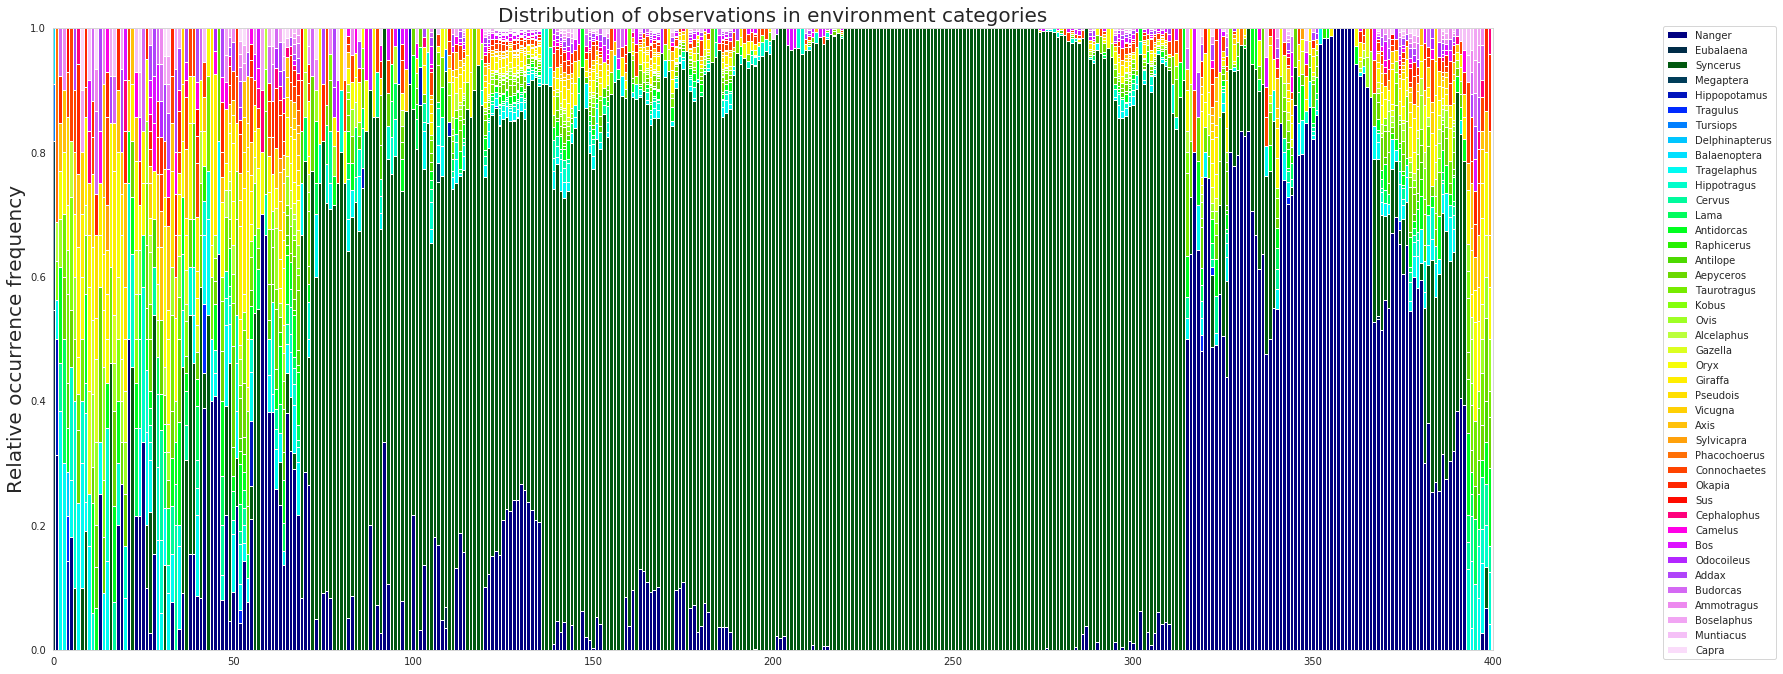

In [14]:
map_field_name = 'Taxonomy_Genus'

mammal_table = table.filter(md.loc[md['Taxonomy_Order'] == 'Cetartiodactyla'].index,
                            axis='sample', inplace=False)

mammal_table.filter(lambda val, id_, md: (val > 0).sum() >= 10,
                    axis='observation',
                    inplace=True)

mammal_otu = make_env_table(mammal_table,
                            md,
                            map_field_name)

fig = plot_tax_env(mammal_otu,
                   reorder=True,
                   xlabels=None, 
                   num_otu=num_otus,
                   env_colors=None, 
                   env_cmap=cmap,
                   wide=True)


fig.savefig(join(fig_dir, 'cetartiodactyla_otu.genus.pdf'),
            bbox_inches='tight')

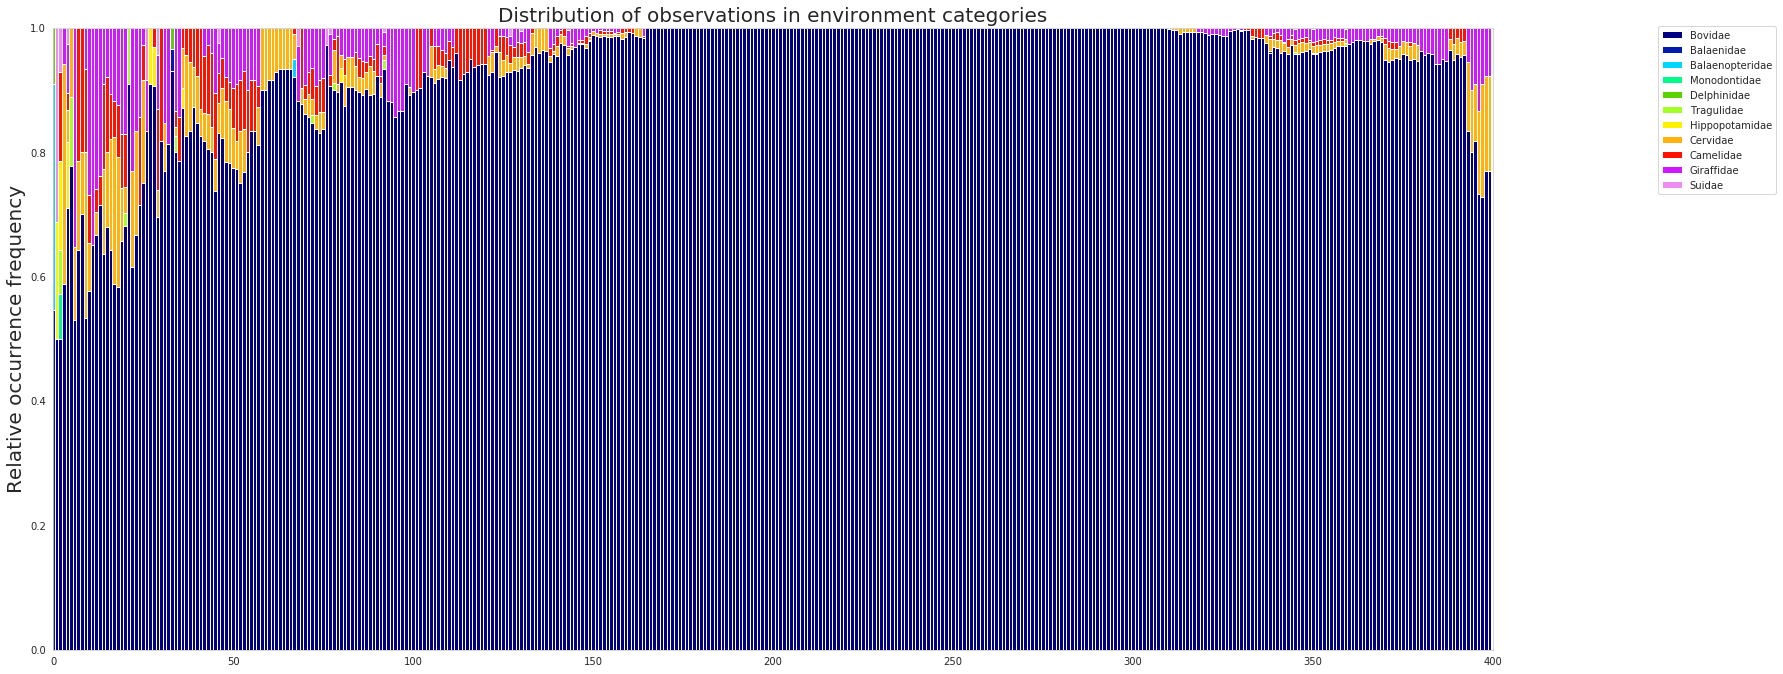

In [15]:
map_field_name = 'Taxonomy_Family'

mammal_table = table.filter(md.loc[md['Taxonomy_Order'] == 'Cetartiodactyla'].index,
                            axis='sample', inplace=False)

mammal_table.filter(lambda val, id_, md: (val > 0).sum() >= 10,
                    axis='observation',
                    inplace=True)

mammal_otu = make_env_table(mammal_table,
                            md,
                            map_field_name)

fig = plot_tax_env(mammal_otu,
                   reorder=True,
                   xlabels=None, 
                   num_otu=num_otus,
                   env_colors=None, 
                   env_cmap=cmap,
                   wide=True)


fig.savefig(join(fig_dir, 'cetartiodactyla_otu.family.pdf'),
            bbox_inches='tight')

## Birds

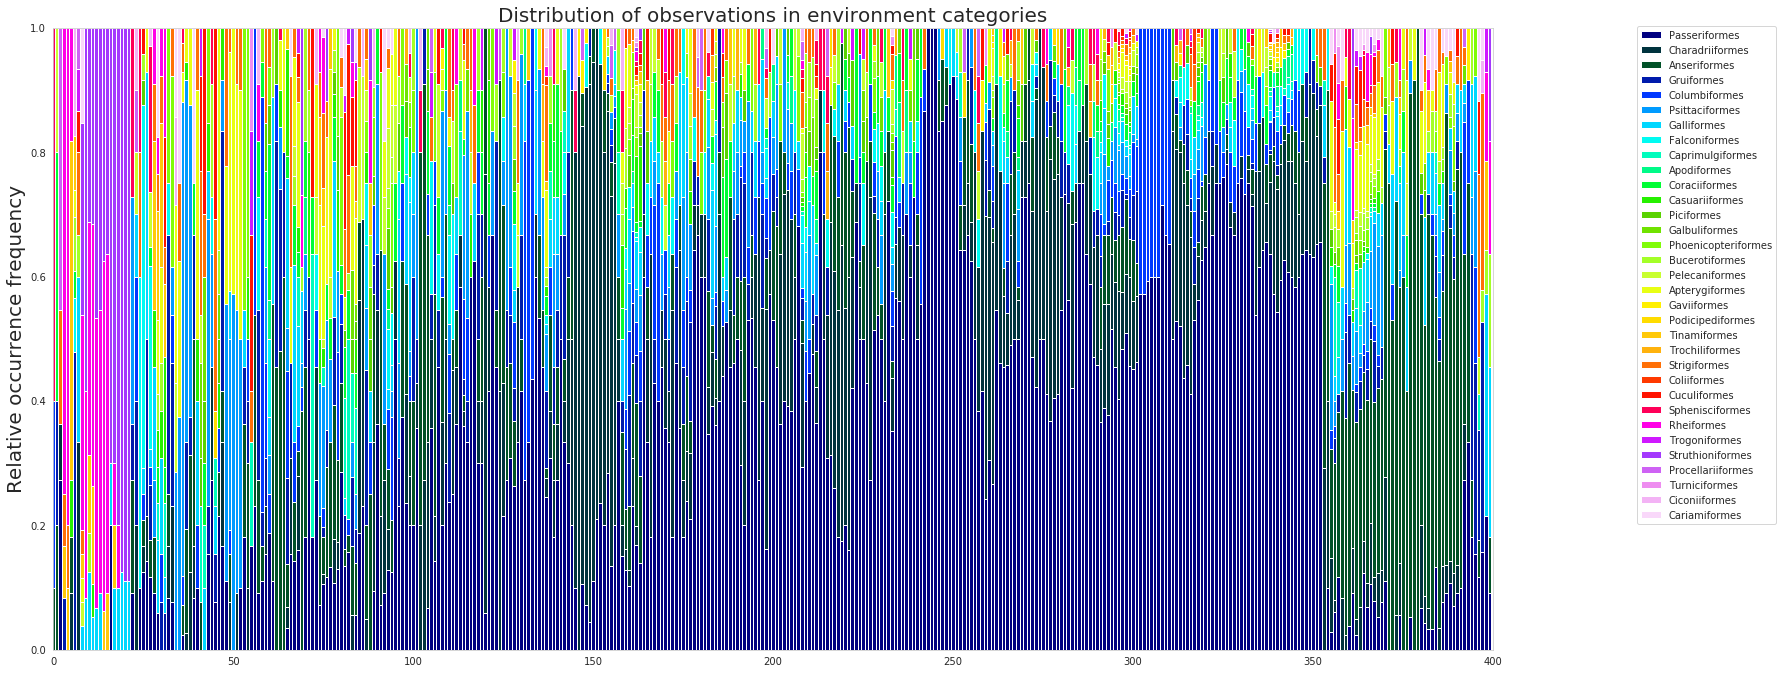

In [16]:
map_field_name = 'Taxonomy_Order'

bird_table = table.filter(md.loc[md['Taxonomy_Class'] == 'Aves'].index,
                            axis='sample', inplace=False)

bird_table.filter(lambda val, id_, md: (val > 0).sum() >= 10,
                  axis='observation',
                  inplace=True)

bird_otu = make_env_table(bird_table,
                          md,
                          map_field_name)


fig = plot_tax_env(bird_otu,
                   reorder=True,
                   xlabels=None, 
                   num_otu=num_otus,
                   env_colors=None, 
                   env_cmap=cmap,
                   wide=True)


fig.savefig(join(fig_dir, 'bird_otu.order.pdf'),
            bbox_inches='tight')

## Herps 

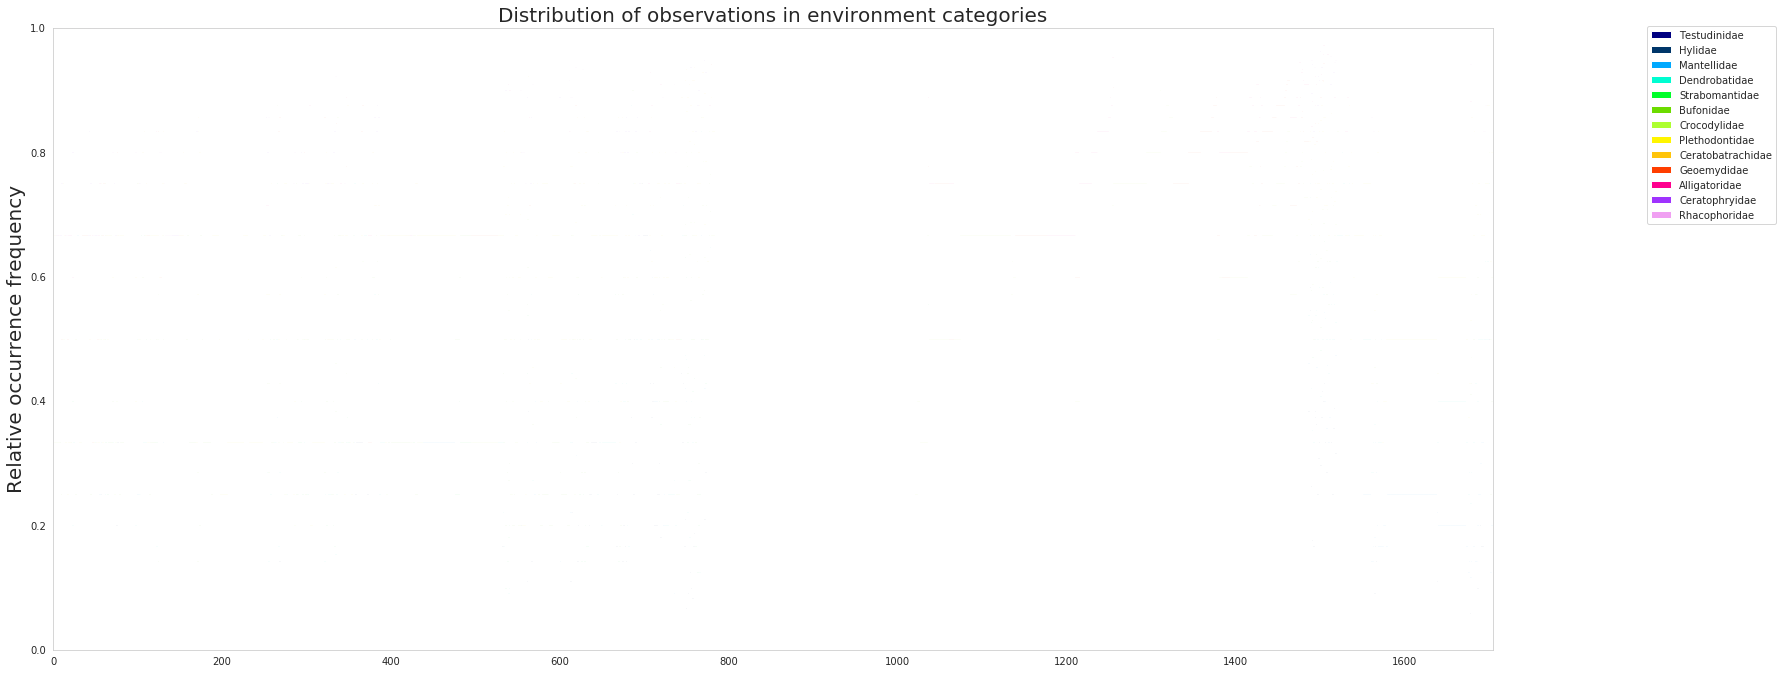

In [42]:
map_field_name = 'Taxonomy_Family'

herp_table = table.filter(md.loc[md['Taxonomy_Class'].isin(['Lepidosaura',
                                                            'Amphibia',
                                                            'Chelonia',
                                                            'Crocodylomorpha'])].index,
                          axis='sample', inplace=False)

herp_table.filter(lambda val, id_, md: (val > 0).sum() >= 3,
                  axis='observation',
                  inplace=True)

herp_env = make_env_table(herp_table,
                        md,
                        map_field_name)

fig = plot_tax_env(herp_env,
                   reorder=True,
                   xlabels=None, 
#                    num_otu=num_otus,
                   env_colors=None, 
                   env_cmap=cmap,
                   wide=True)


fig.savefig(join(fig_dir, 'herp_otu.family.pdf'),
            bbox_inches='tight')

## Evenness statistics

How evenly distributed across host categories are the ASVs?

In [18]:
from skbio.diversity.alpha import pielou_e

So pielou's evenness gives a good representation of whether an ASV is evenly distributed across available categories.

But, there is still the matter of uneven sampling across categories. We want a standardized effect size (SES) for pielou's `e` that finds `e` on the given dataset, but then also for each ASV calculates `e` from an OTU table with randomized observation assignments. By taking the difference in mean `e` divided by the standard deviation of permuted `e` values, we'll have an idea of just how uneven the distribution of a particular ASV distribution is relative to chance (while accounting for differences in observation frequency and sampling effort across taxa). 

#### Function: permute the row entries in an OTU table

In [19]:
data = np.matrix([[ 1.,  0.,  0.,  0.,  0.],
                [ 0.,  0.,  2.,  0.,  3.],
                [ 0.,  0.,  0.,  0.,  0.],
                [ 0.,  0.,  0.,  4.,  0.]])

test_otu = Table(data,
                 [0, 1, 2, 3],
                 [0, 1, 2, 3, 4])

exp_data = np.matrix([[ 0.,  0.,  0.,  1.,  0.],
                    [ 0.,  2.,  3.,  0.,  0.],
                    [ 0.,  0.,  0.,  0.,  0.],
                    [ 4.,  0.,  0.,  0.,  0.]])

def shuffle_otu_table_rows(otu):
    data = np.array(otu.matrix_data.todense())

    for ndx in np.ndindex(data.shape[:-1]):
        np.random.shuffle(data[ndx])
    
    out = Table(data, 
                otu.ids(axis='observation'),
                otu.ids(axis='sample'))
    return(out)

np.random.seed(1)
obs_otu = shuffle_otu_table_rows(test_otu)

np.testing.assert_array_equal(obs_otu.matrix_data.todense(), 
                              exp_data)

#### Function: calculate Pielou's e SES for an OTU table

This function calculates Pielou's evenness statistic for ASVs in an OTU table, 
in terms of their distribution across different environment types, as defined
by metadata column specified by the `map_field_name` argument. In this case,
we'll be using `Taxonomy_Order`, showing the evenness of taxonomic orders 
spanned by the different samples in which an ASV is found. 

Because our sampling is not itself balanced across taxonomic orders, instead
of computing the raw statistic, we'll calculate a standard effect size. This
SES uses the OTU table with samples permuted within each OTU, such that each
OTU is found in the same number of samples in the permuted table as in the raw,
but those samples are chosen randomly from across the dataset independently 
for each OTU. This does NOT retain the observed alpha diversity distribution 
for samples in the dataset. (I don't this this should matter anyway, because
we're calculating SES independently for each OTU). The SES is calculated as
the raw statistic for an ASV, minus the mean of the permuted statistics, 
divided by the standard deviation of the permuted statistics.

In [20]:
def pielou_ses(otu, md, map_field_name, n=100):
    
    
    env = make_env_table(otu,
                         md,
                         map_field_name)

    rel = env.div(env.sum(axis=1), axis=0).fillna(0)
    
    obs = rel.apply(pielou_e, axis=1)
    
    obs.fillna(0, inplace=True)
    
    perm_list = []
    for i in range(n):
        print("permutation %s" % i)
        otu_p = shuffle_otu_table_rows(otu)
        env_p = make_env_table(otu_p,
                               md,
                               map_field_name)
        rel_p = env_p.div(env_p.sum(axis=1), axis=0).fillna(0)
        p = rel_p.apply(pielou_e, axis=1)
        
        perm_list.append(p)
    
    perm_df = pd.concat(perm_list, axis=1)
    perm_df.fillna(0, inplace=True)
    
    ses = (obs - perm_df.mean(axis=1)) / perm_df.std(axis=1)
    
    return(ses)
        

In [21]:
map_field_name = 'Taxonomy_Order'

outdir = '../specificity_stats'

makedirs(outdir, exist_ok=True)

rerun = False

In [22]:
mammal_table = table.filter(md.loc[md['Taxonomy_Class'] == 'Mammalia'].index,
                            axis='sample', inplace=False)

mammal_table.filter(lambda val, id_, md: (val > 0).sum() >= 10,
                    axis='observation',
                    inplace=True)

if rerun:
    mammal_pielou_ses = pielou_ses(mammal_table, md, map_field_name, n=100)
    mammal_pielou_ses.to_csv(join(outdir, 'mammal_pielou_ses.csv'))
else:
    mammal_pielou_ses = pd.read_csv(join(outdir, 'mammal_pielou_ses.csv'),
                                    index_col=0, header=None, squeeze=True)

In [23]:
bird_table = table.filter(md.loc[md['Taxonomy_Class'] == 'Aves'].index,
                            axis='sample', inplace=False)

bird_table.filter(lambda val, id_, md: (val > 0).sum() >= 10,
                  axis='observation',
                  inplace=True)

if rerun:
    bird_pielou_ses = pielou_ses(bird_table, md, map_field_name, n=100)
    bird_pielou_ses.to_csv(join(outdir, 'bird_pielou_ses.csv'))
else:
    bird_pielou_ses = pd.read_csv(join(outdir, 'bird_pielou_ses.csv'),
                                  index_col=0, header=None, squeeze=True)

In [102]:
class_colors = {'Mammalia': '#6a3d9a',
          'Aves': '#EACB47'}

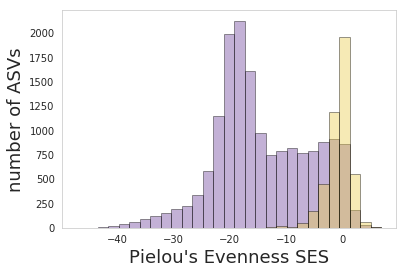

In [154]:
plt.figure()

bins = np.linspace(min(mammal_pielou_ses), max(bird_pielou_ses), num=30)

ax1 = sns.distplot(mammal_pielou_ses, bins=bins,
                   color=colors['Mammalia'],
                   kde=False,
                   hist_kws=dict(edgecolor='k', lw=1),
                   label='mammals')
ax2 = sns.distplot(bird_pielou_ses, bins=bins, 
                   color=class_colors['Aves'], 
                   kde=False, 
                   hist_kws=dict(edgecolor='k', lw=1),
                   label='birds')

plt.xlabel("Pielou's Evenness SES", fontsize=18)
plt.ylabel("number of ASVs", fontsize=18)
# plt.legend()

plt.savefig(join(outdir, 'pielou_ses_distribution.pdf'))

As we can see, there are a lot more ASVs found associated with mammals than with
birds, and they tend to be much more specific at the level of host order. In fact,
given that we have a similar number of samples for birds and mammals, the one 
observation should follow from the other.

The mammalian SES distribution is also bimodal, which is interesting.

### Plotting Pielou SES averages per order

We want to see how the Pielou's e SES breaks down for the ASVs associated with different 
orders of animals. What we'll do is find the average Pielou's e SES for each sample in 
the dataset, and then plot those per-sample averages split up by different host taxonomic
levels.

#### Function: calculate the average SES value per sample

This function takes the SES list (a pandas Series object, with ASV ids as keys) and
an OTU table, and for each sample in the OTU table, calculates the average SES of
the ASVs that are 1) found in that table, and 2) present in the SES list. (For some
ASVs that are present in a sample there will be no calculated SES value, if for
example that ASV was not present across the minimum number of samples required for
calculating the SES.)

This calculates both a straight mean and an abundance-weighted mean -- essentially,
what is the specificity SES of the average *taxon* in a sample, and what is the SES
of the average *read*.

In [25]:

def get_asv_ses_avgs(ses_list, table):
    ses_mean = []
    ses_wtd = []
    for sample in table.ids(axis='sample'):
        try:
            # get ASVs associated with sample
            d = table.data(sample)
            asvs = table.ids(axis='observation')[d.nonzero()[0]]
            # get their abundances in the sample
            abunds = d[d.nonzero()[0]]

            # get the SES values for those ASVs
            sesses = ses_list.loc[ses_list.index.intersection(asvs)].reindex(asvs)
            
            if sesses.dropna().shape[0] > 0:
                # get the means
                ses_mean.append(np.average(sesses[~np.isnan(sesses)]))
                ses_wtd.append(np.average(sesses[~np.isnan(sesses)],
                                          weights=abunds[~np.isnan(sesses)]))
            else:
                ses_mean.append(np.nan)
                ses_wtd.append(np.nan)
                
        except(KeyError):
            print(sample)
    
    df = pd.DataFrame({'mean': ses_mean,
                       'weighted_mean': ses_wtd}, 
                      index=table.ids(axis='sample'))
    return(df)


In [26]:
mam_ses_df = get_asv_ses_avgs(mammal_pielou_ses, table)

In [27]:
bird_ses_df = get_asv_ses_avgs(bird_pielou_ses, table)

In [28]:
mam_ses_df.columns = ['Pielou_e_mammal_%s' % x for x in mam_ses_df.columns]

In [29]:
bird_ses_df.columns = ['Pielou_e_bird_%s' % x for x in bird_ses_df.columns]

In [30]:
md_ses = pd.concat([md, mam_ses_df, bird_ses_df],
          axis=1)

In [31]:
md_ses = md_ses[['Taxonomy_Order','Taxonomy_Class','Taxonomy_Family','Taxonomy_Genus',
                 'Pielou_e_mammal_mean', 'Pielou_e_mammal_weighted_mean',
                 'Pielou_e_bird_mean', 'Pielou_e_bird_weighted_mean']]

In [32]:
md_ses_melt = pd.melt(md_ses, 
                      id_vars = ['Taxonomy_Order','Taxonomy_Class','Taxonomy_Family','Taxonomy_Genus'])
md_ses_melt = md_ses_melt.dropna()

### Plots

We'll do boxplots using [Plotnine](https://plotnine.readthedocs.io), a `ggplot` port for Python.

#### Boxplot: birds and mammals

This faceted boxplot shows each of the four calculated SES value for birds and 
mammals, broken down by taxonomic order. 

This means that bird samples will also have mean SES values for ASVs *calculated
based on the ASVs distribution across mammalian orders.* The reasoning here is
that we know that some ASVs that are found in birds are also found in mammals
and vice versa, so are those ASVs shared between classes also among the least
specific within a class?

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 16 x 16 in image.
  from_inches(height, units), units))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../specificity_stats/pielou_ses_boxplot.birds.mammals.pdf
  warn('Filename: {}'.format(filename))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future

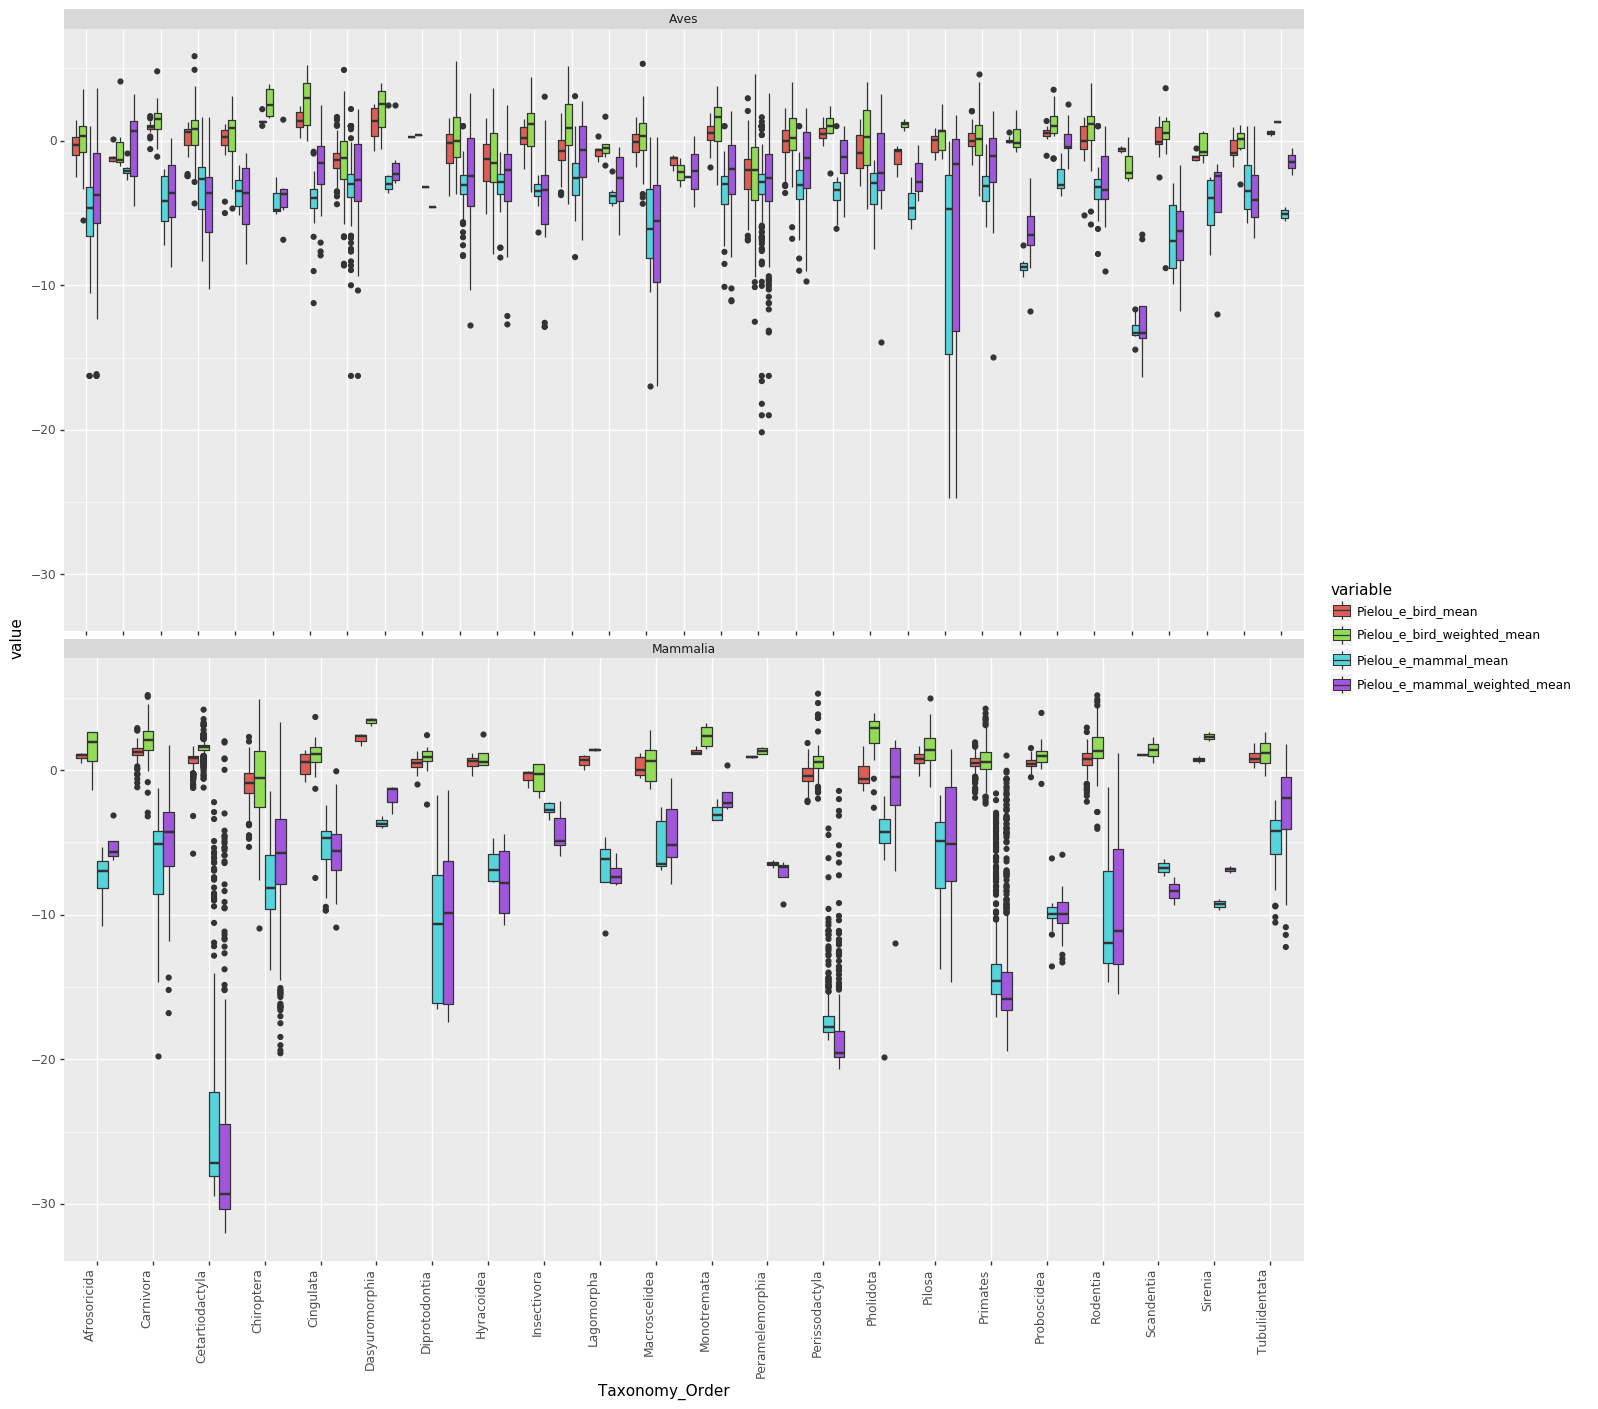

<ggplot: (8736447394438)>

In [43]:
p = (ggplot(md_ses_melt.loc[md_ses_melt['Taxonomy_Class'].isin(['Mammalia',
                                                            'Aves'])],) +
        geom_boxplot(aes(x = 'Taxonomy_Order', 
                         y = 'value',
                         fill = 'variable')) +
        facet_wrap('~Taxonomy_Class',
                   scales='free_x',
                   ncol=1) +
        theme(figure_size=(16, 16), 
              axis_text_x=element_text(rotation=90, hjust=1)))

p.save(join(outdir, 'pielou_ses_boxplot.birds.mammals.pdf'),
       width=16, height=16)

p

#### Boxplot: mammals

And the same, but just zooming in on the mammals. We can see that the more herbivorous 
orders tend to have the more specific (more highly negative) ASVs on average, with 
Cetartiodactyla taking the cake. The mammalian ASVs that also show up in birds also
tend to be quite evenly spread on average among birds (SES > 0).

There may also be slight trend where the orders with the highest specificity also tend
to have more more-specific weighted means, and vice versa for the orders with the
lowest average speficity, but that's marginal.

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 16 x 10 in image.
  from_inches(height, units), units))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../specificity_stats/pielou_ses_boxplot.mammals.pdf
  warn('Filename: {}'.format(filename))


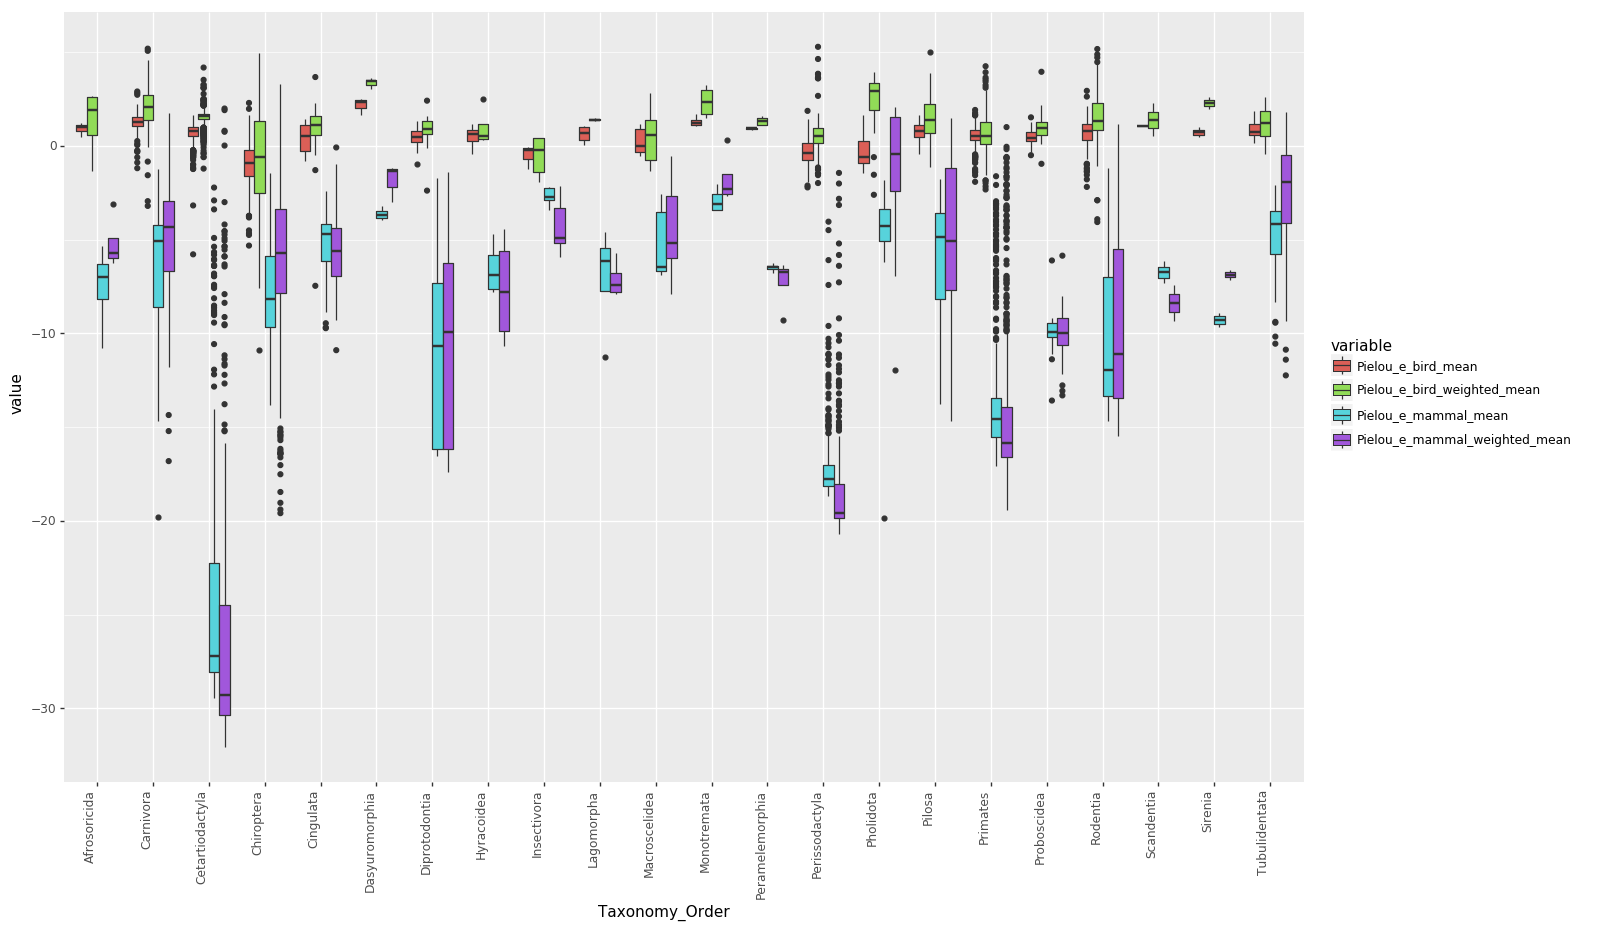

<ggplot: (-9223363300421347128)>

In [48]:
p = (ggplot(md_ses_melt.loc[md_ses_melt['Taxonomy_Class'] == 'Mammalia'],) +
     geom_boxplot(aes(x = 'Taxonomy_Order', 
                      y = 'value',
                      fill = 'variable')) +
    #  facet_wrap('~Taxonomy_Class',
    #             scales='free_x',
    #             ncol=1) +
     theme(figure_size=(16, 10), 
           axis_text_x=element_text(rotation=90, hjust=1)))

p.save(join(outdir, 'pielou_ses_boxplot.mammals.pdf'),
       width=16, height=10)

p

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 16 x 10 in image.
  from_inches(height, units), units))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../specificity_stats/pielou_ses_boxplot.primates.pdf
  warn('Filename: {}'.format(filename))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future

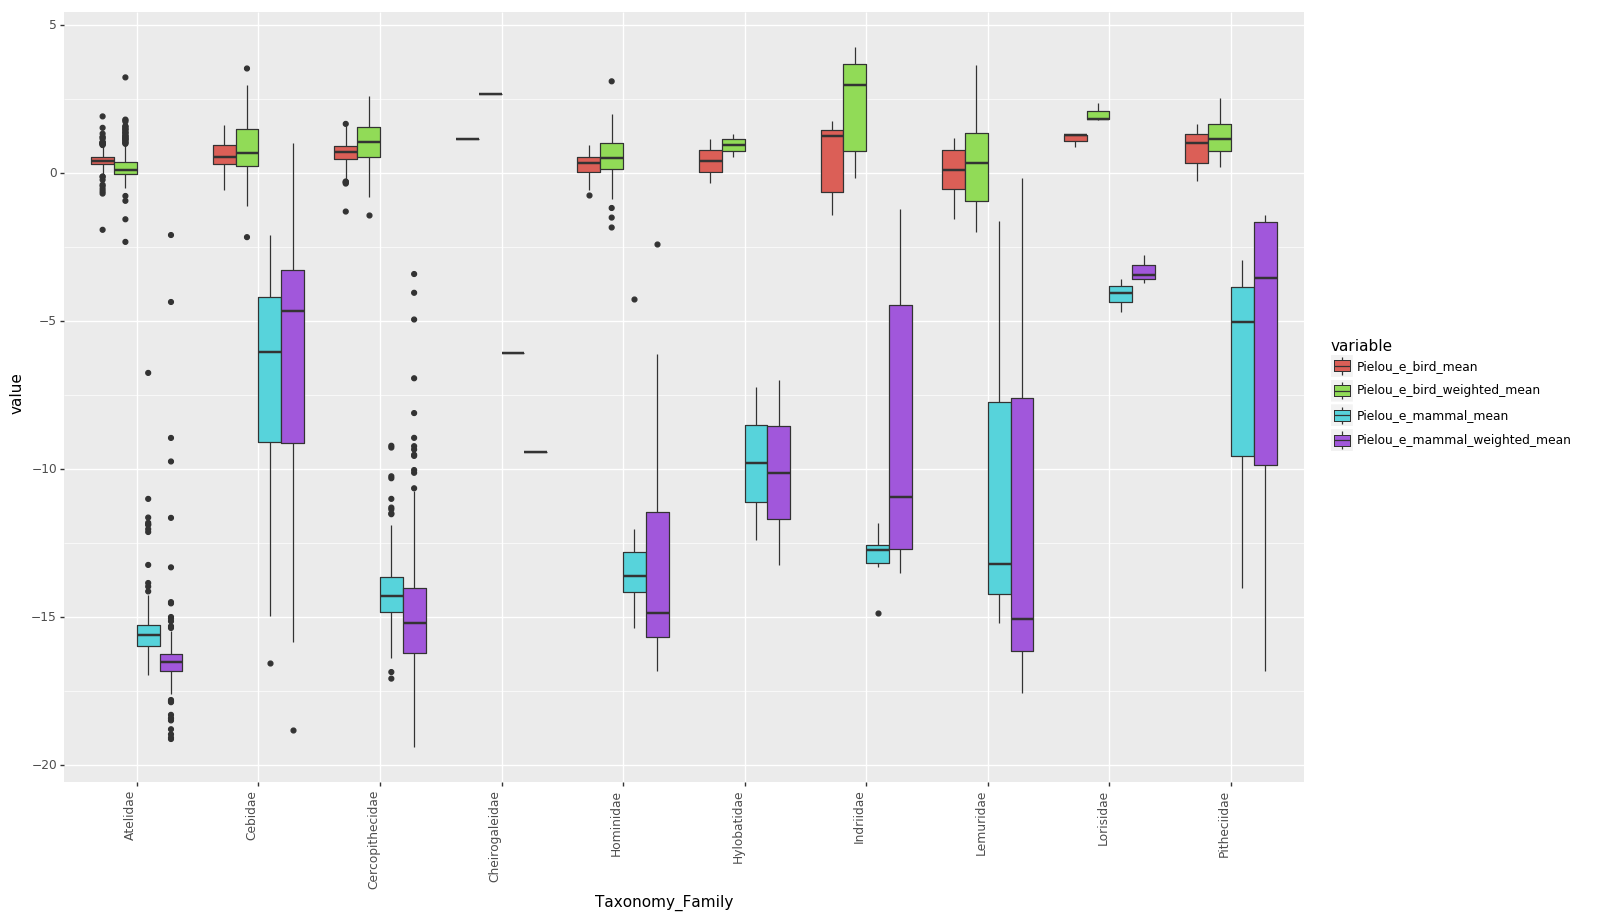

<ggplot: (8736433760972)>

In [49]:
p = (ggplot(md_ses_melt.loc[md_ses_melt['Taxonomy_Order'] == 'Primates'],) +
     geom_boxplot(aes(x = 'Taxonomy_Family', 
                      y = 'value',
                      fill = 'variable')) +
    #  facet_wrap('~Taxonomy_Class',
    #             scales='free_x',
    #             ncol=1) +
     theme(figure_size=(16, 10), 
           axis_text_x=element_text(rotation=90, hjust=1)))

p.save(join(outdir, 'pielou_ses_boxplot.primates.pdf'),
       width=16, height=10)

p

#### Boxplot: birds

Now a zoom in on the bird results. On average the bird specificity is very low, not really
different from zero (random). The Passeriformes *might* be just slightly below zero, but
they also form the bulk of the dataset, and I wonder if there is also a tiny bit of some
sort of bias that sneaks in somehow. 

Intriguingly, although the ASVs the show up in both birds and mammals also tend to be among
the lowest specificity when calculated based on their distribution among mammals, the
flightless birds harbor the ASVs whose distribution in mammals is among the most specific.

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 16 x 10 in image.
  from_inches(height, units), units))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../specificity_stats/pielou_ses_boxplot.birds.pdf
  warn('Filename: {}'.format(filename))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future ve

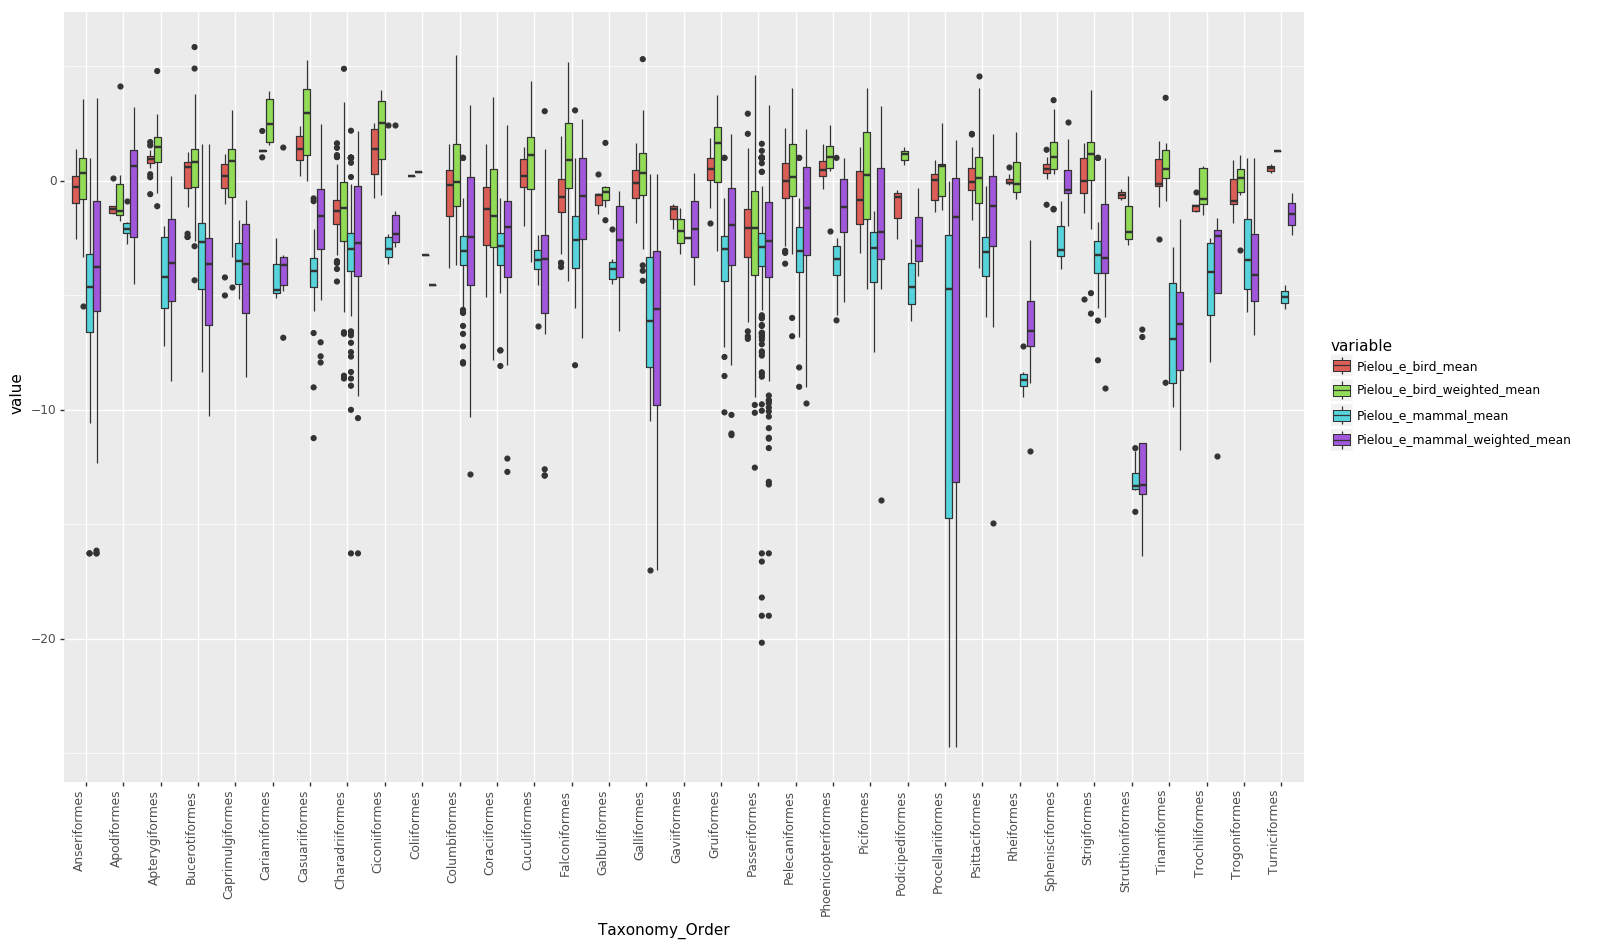

<ggplot: (8736433533104)>

In [50]:
p = (ggplot(md_ses_melt.loc[md_ses_melt['Taxonomy_Class'] == 'Aves'],) +
     geom_boxplot(aes(x = 'Taxonomy_Order', 
                      y = 'value',
                      fill = 'variable')) +
    #  facet_wrap('~Taxonomy_Class',
    #             scales='free_x',
    #             ncol=1) +
     theme(figure_size=(16, 10), 
           axis_text_x=element_text(rotation=90, hjust=1)))

p.save(join(outdir, 'pielou_ses_boxplot.birds.pdf'),
       width=16, height=10)

p

### Specificity of different bacterial taxa

We can also breakdown the calculated evenness SES across different bacterial taxa.
Do some tend more towards specificity than others?

In [51]:
tax['pielou_ses_mammals'] = mammal_pielou_ses

In [52]:
tax['pielou_ses_birds'] = bird_pielou_ses

In [53]:
tax_ses = tax.dropna(thresh=2)

In [54]:
tax_l = tax_ses['Taxon'].str.split('; ', expand = True)

In [55]:
tax_l.columns = ['Kingdom',
                 'Phylum',
                 'Class',
                 'Order',
                 'Family',
                 'Genus',
                 'Species']

In [56]:
tax_ses = pd.concat([tax_ses,
                     tax_l],
          axis=1)

In [57]:
tax_ses_mam = tax_ses.loc[~tax_ses['pielou_ses_mammals'].isna(),]
tax_ses_bird = tax_ses.loc[~tax_ses['pielou_ses_birds'].isna(),]

#### Boxplot: mammalian specificity across bacterial phyla

This looks at SES effect sizes calculated based on distribution across mammalian
orders. 

We can see that there are too many phyla, and that some are very low-specificity
(e.g. Acidobacteria, Crenarchaeota, Planctomycetes) and some are very high-
specificity (e.g. Spirochaetes, Lentispherae, Fibrobacteres, Elusimicrobia).
Most span a fair range. 

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 16 x 10 in image.
  from_inches(height, units), units))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../specificity_stats/pielou_ses_boxplot.mam-ses.bacteria.phylum.pdf
  warn('Filename: {}'.format(filename))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not al

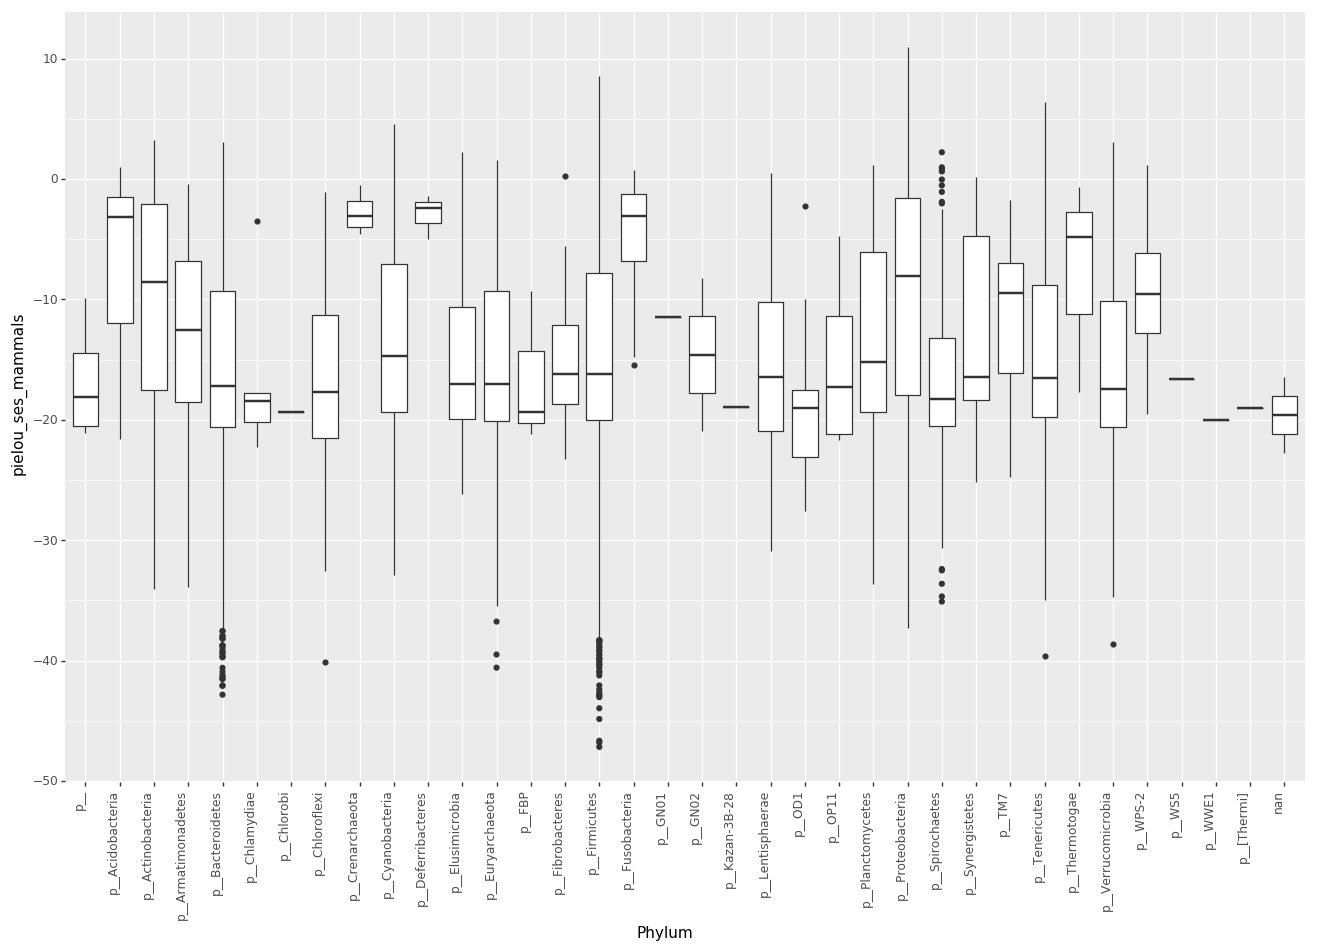

<ggplot: (-9223363300428023110)>

In [59]:
p = (ggplot(tax_ses_mam) +
     geom_boxplot(aes(x = 'Phylum',
                      y = 'pielou_ses_mammals')) +
     theme(figure_size=(16, 10), 
           axis_text_x=element_text(rotation=90, hjust=1))
    )

p.save(join(outdir, 'pielou_ses_boxplot.mam-ses.bacteria.phylum.pdf'),
       width=16, height=10)

p

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)


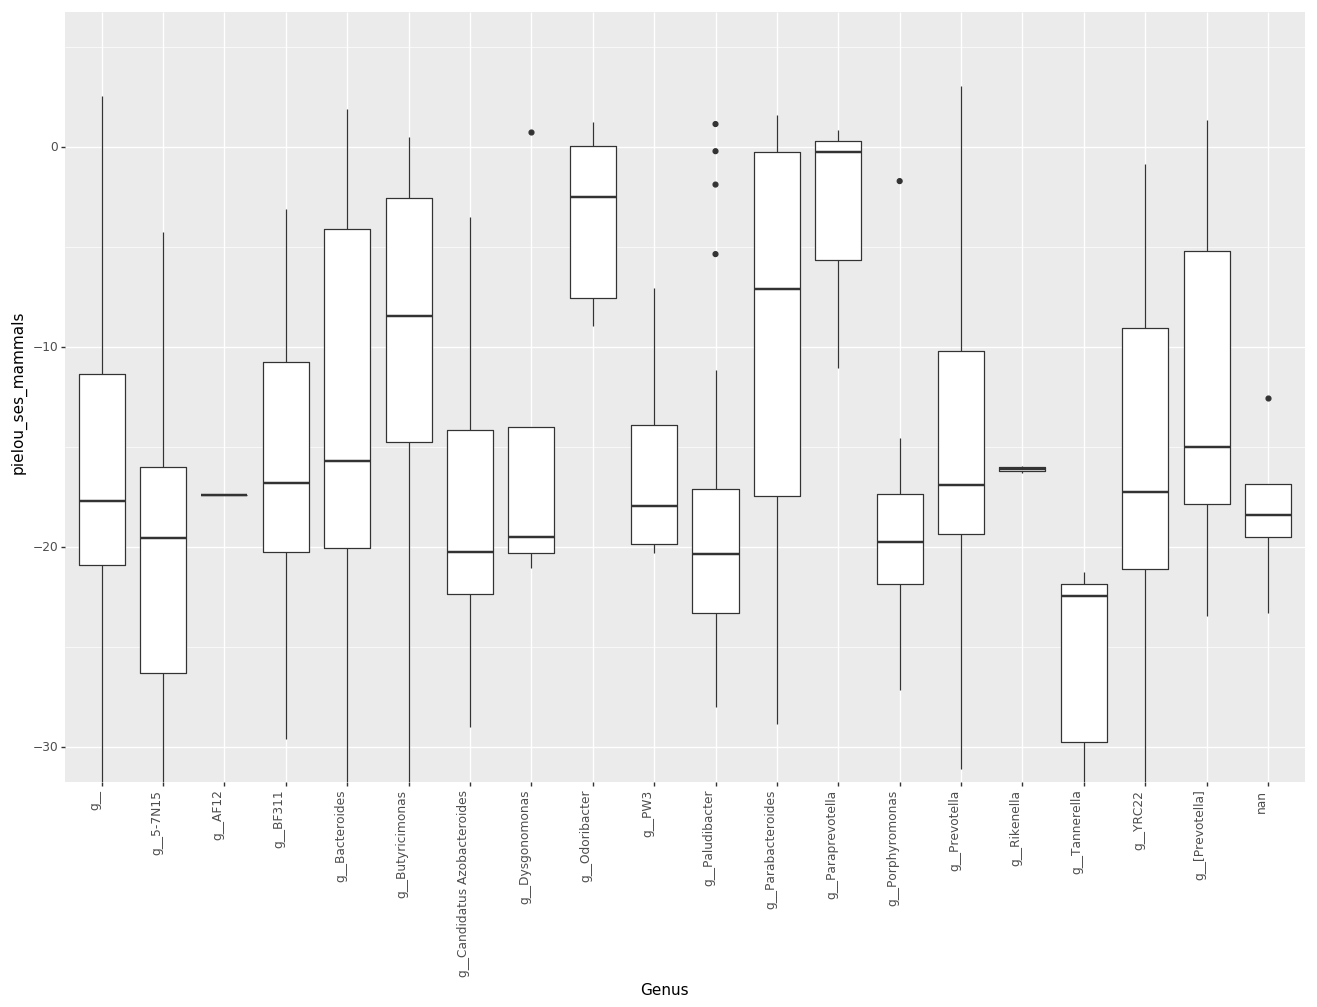

<ggplot: (8736426616191)>

In [60]:
q = (ggplot(tax_ses_mam.loc[(tax_ses_mam['Phylum'] == 'p__Bacteroidetes') &
                            (tax_ses_mam['Class'] == 'c__Bacteroidia')]) +
     geom_boxplot(aes(x = 'Genus',
                      y = 'pielou_ses_mammals')) +
#      facet_wrap('~Class', 
#                 scales='free_x') +
     theme(figure_size=(16, 10), 
           axis_text_x=element_text(rotation=90, hjust=1)) +
      coord_cartesian(ylim=(-30.,5.))
    )

q

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 16 x 10 in image.
  from_inches(height, units), units))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../specificity_stats/pielou_ses_boxplot.mam-ses.bacteria.class.per-phylum.pdf
  warn('Filename: {}'.format(filename))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is n

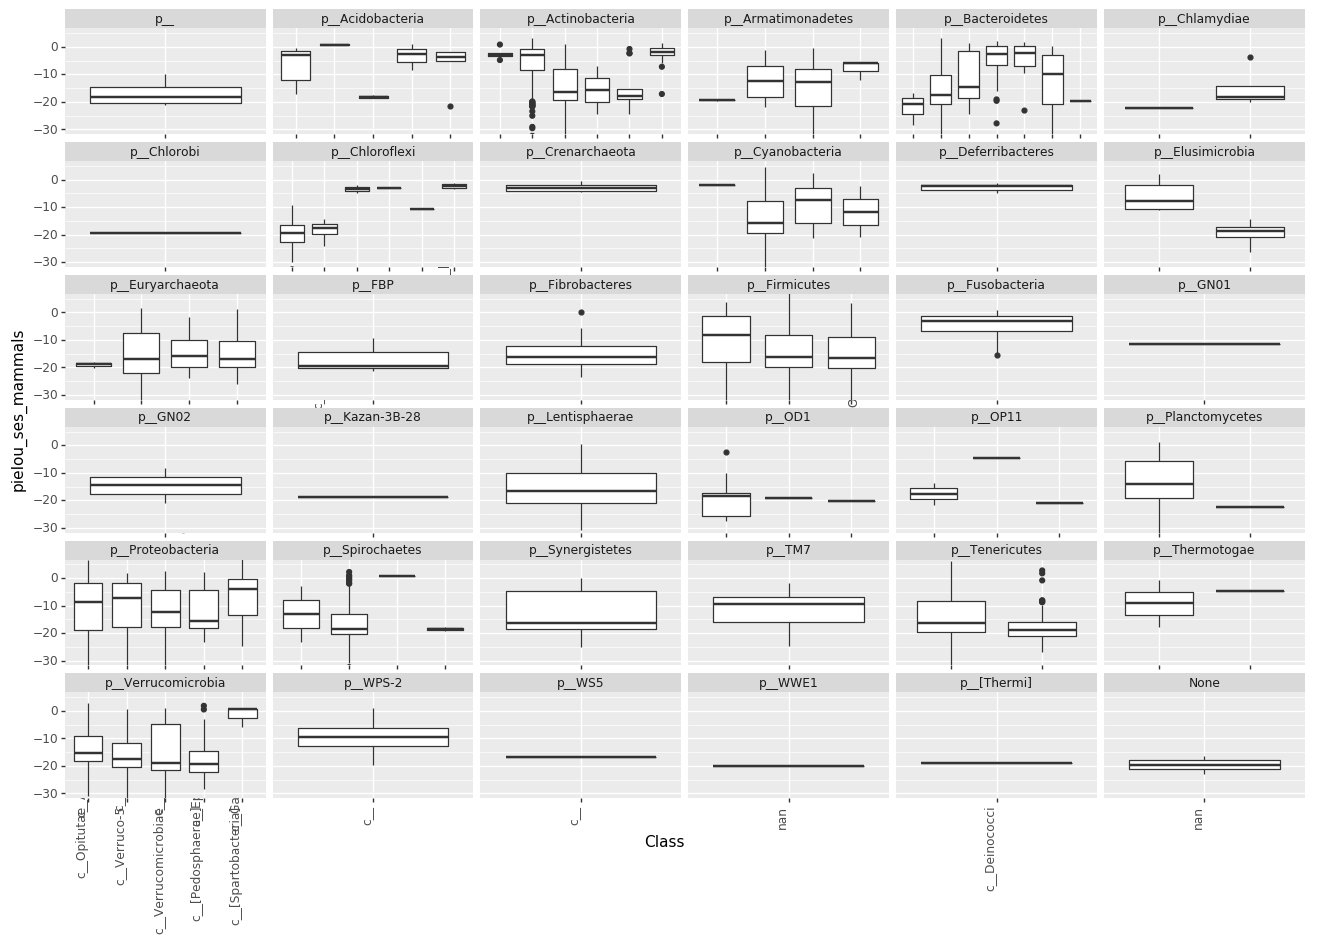

<ggplot: (-9223363300428310314)>

In [61]:
p = (ggplot(tax_ses_mam) +
     geom_boxplot(aes(x = 'Class',
                      y = 'pielou_ses_mammals')) +
     coord_cartesian(ylim=(-30,5)) +
     facet_wrap('~Phylum', 
                scales='free_x') +
     theme(figure_size=(16, 10), 
           axis_text_x=element_text(rotation=90, hjust=1))
    )

p.save(join(outdir, 'pielou_ses_boxplot.mam-ses.bacteria.class.per-phylum.pdf'),
       width=16, height=10)

p

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 16 x 10 in image.
  from_inches(height, units), units))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../specificity_stats/pielou_ses_boxplot.mam-ses.Bacteroidetes.per-class.pdf
  warn('Filename: {}'.format(filename))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not

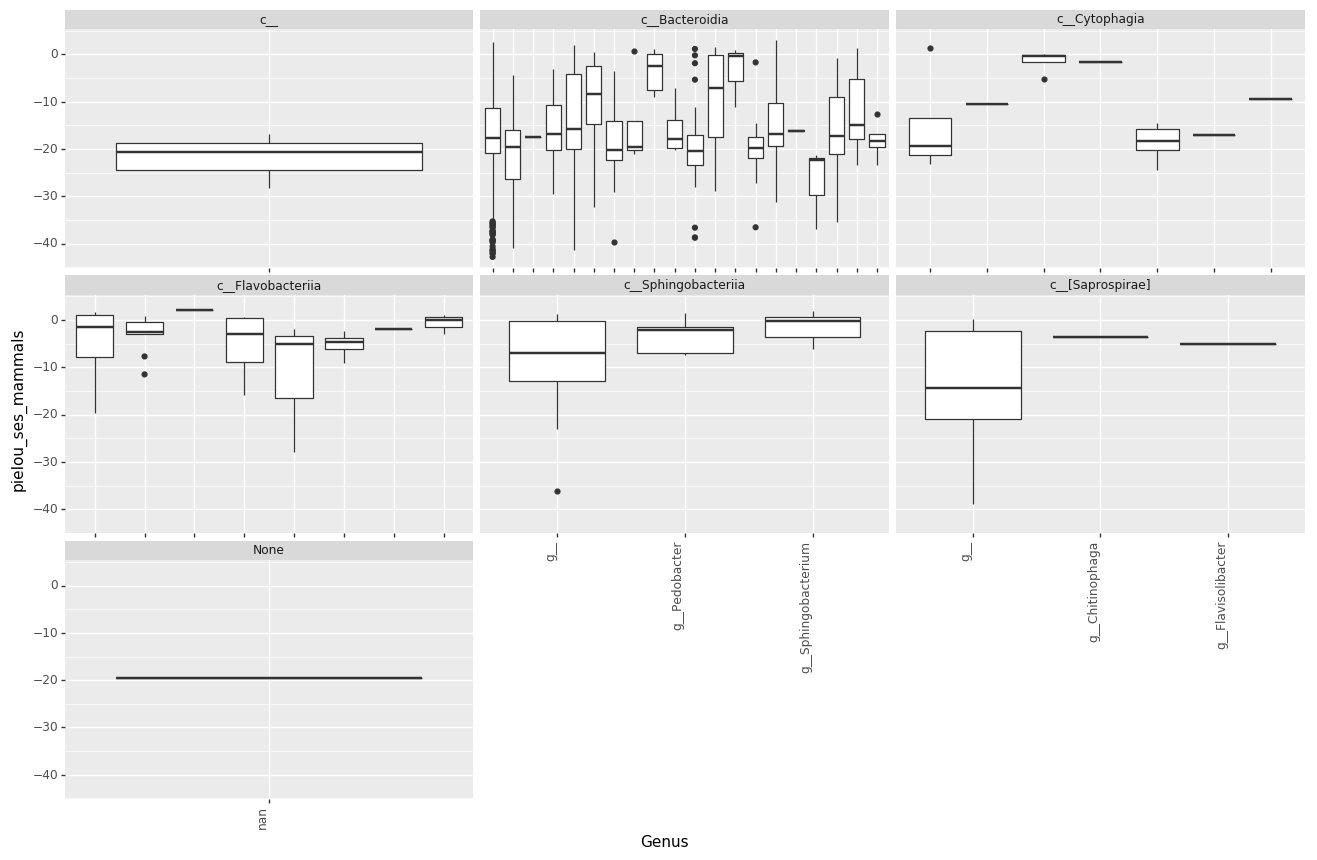

<ggplot: (-9223363300429520012)>

In [62]:
p = (ggplot(tax_ses_mam.loc[tax_ses_mam['Phylum'] == 'p__Bacteroidetes']) +
     geom_boxplot(aes(x = 'Genus',
                      y = 'pielou_ses_mammals')) +
     facet_wrap('~Class', 
                scales='free_x') +
     theme(figure_size=(16, 10), 
           axis_text_x=element_text(rotation=90, hjust=1))
    )

p.save(join(outdir, 'pielou_ses_boxplot.mam-ses.Bacteroidetes.per-class.pdf'),
       width=16, height=10)

p

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 16 x 10 in image.
  from_inches(height, units), units))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../specificity_stats/pielou_ses_boxplot.mam-ses.Bacteroidia.pdf
  warn('Filename: {}'.format(filename))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligne

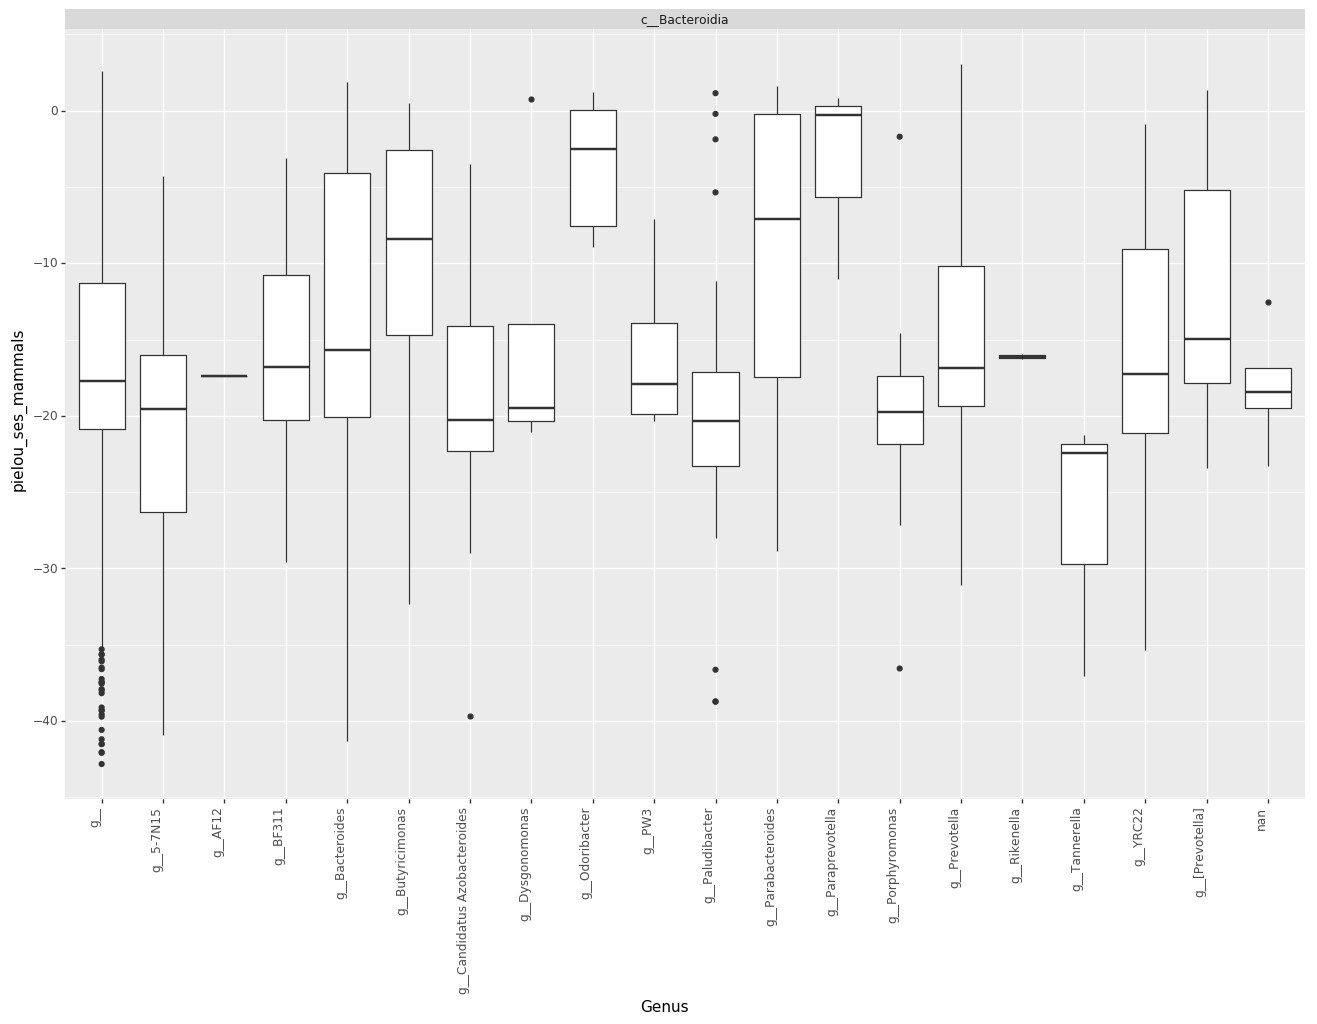

<ggplot: (-9223363300430174243)>

In [63]:
p = (ggplot(tax_ses_mam.loc[(tax_ses_mam['Phylum'] == 'p__Bacteroidetes') &
                            (tax_ses_mam['Class'] == 'c__Bacteroidia')]) +
     geom_boxplot(aes(x = 'Genus',
                      y = 'pielou_ses_mammals')) +
     facet_wrap('~Class', 
                scales='free_x') +
     theme(figure_size=(16, 10), 
           axis_text_x=element_text(rotation=90, hjust=1))
    )

p.save(join(outdir, 'pielou_ses_boxplot.mam-ses.Bacteroidia.pdf'),
       width=16, height=10)

p

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 16 x 10 in image.
  from_inches(height, units), units))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../specificity_stats/pielou_ses_boxplot.mam-ses.Firmicutes.per-class.pdf
  warn('Filename: {}'.format(filename))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not al

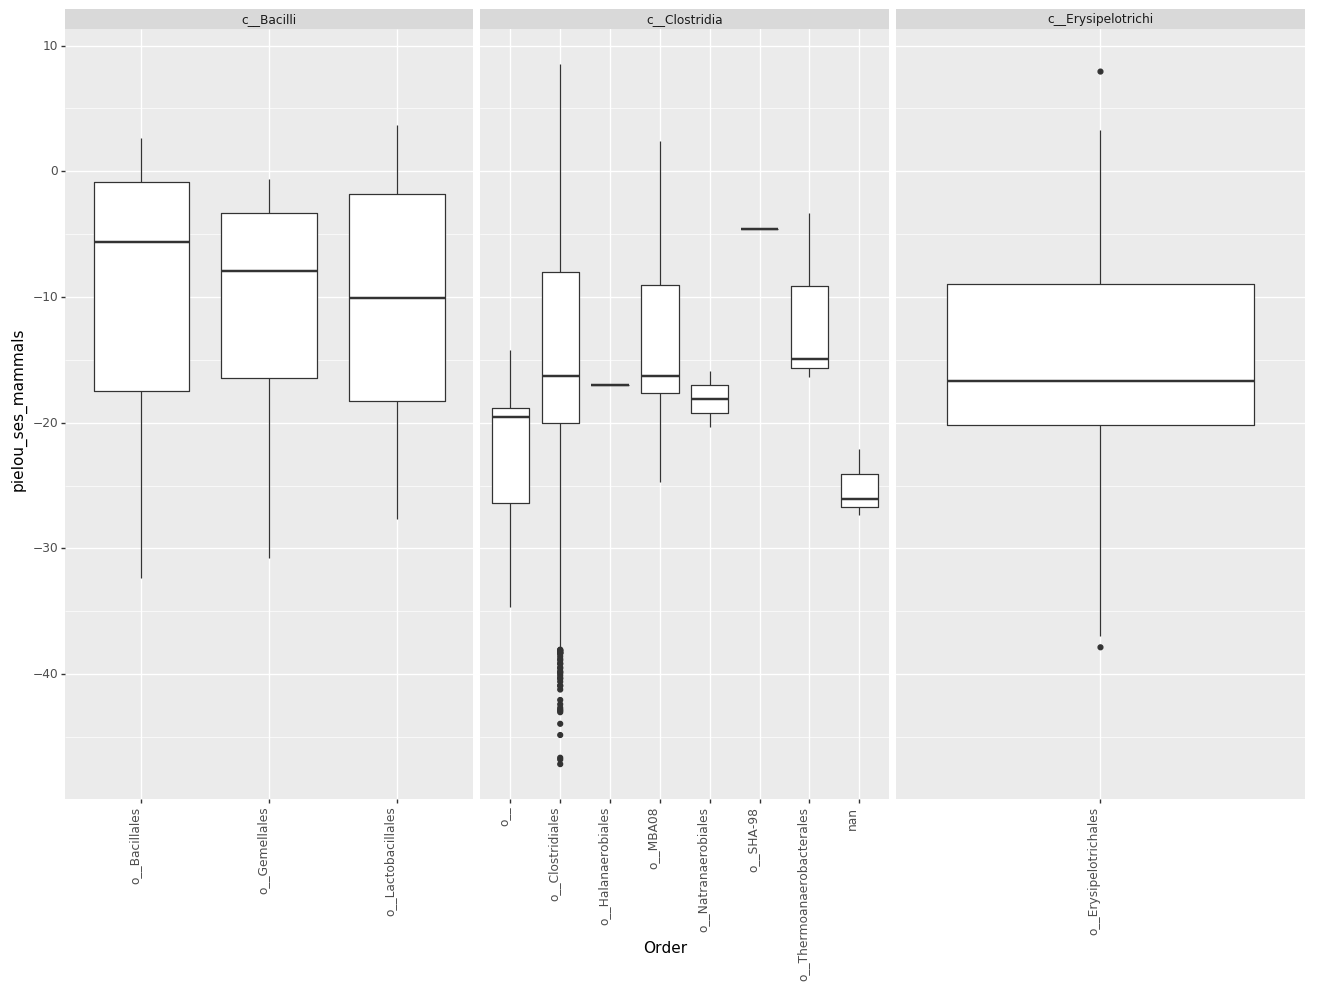

<ggplot: (-9223363300402203269)>

In [64]:
p = (ggplot(tax_ses_mam.loc[tax_ses_mam['Phylum'] == 'p__Firmicutes']) +
     geom_boxplot(aes(x = 'Order',
                      y = 'pielou_ses_mammals')) +
     facet_wrap('~Class', 
                scales='free_x') +
     theme(figure_size=(16, 10), 
           axis_text_x=element_text(rotation=90, hjust=1))
    )

p.save(join(outdir, 'pielou_ses_boxplot.mam-ses.Firmicutes.per-class.pdf'),
       width=16, height=10)

p

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 16 x 10 in image.
  from_inches(height, units), units))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../specificity_stats/pielou_ses_boxplot.mam-ses.Firmicutes.per-class-genus.pdf
  warn('Filename: {}'.format(filename))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is 

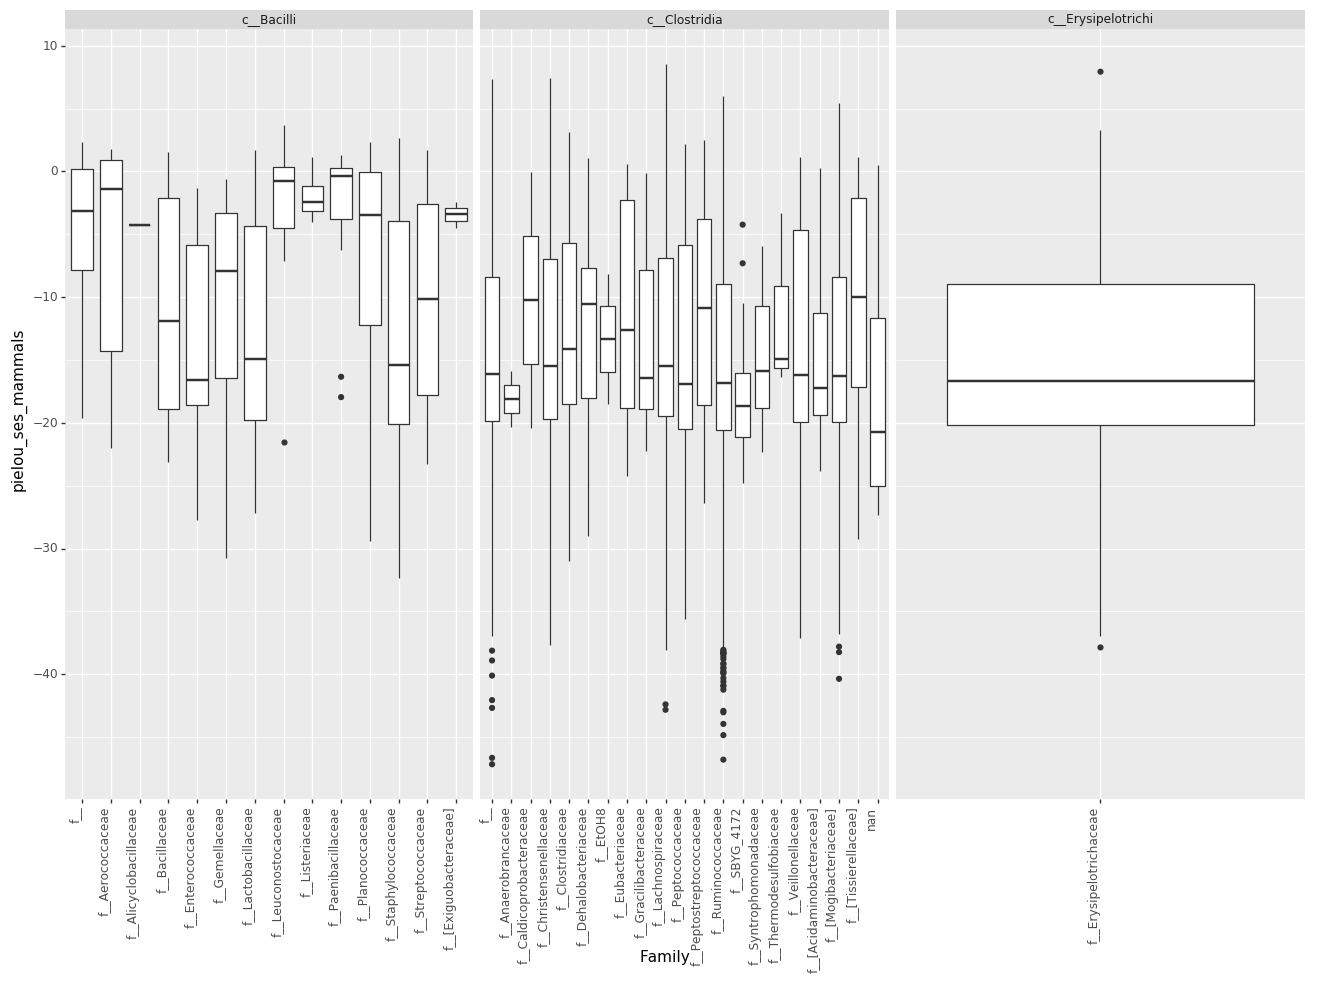

<ggplot: (-9223363300401239815)>

In [65]:
p = (ggplot(tax_ses_mam.loc[tax_ses_mam['Phylum'] == 'p__Firmicutes']) +
     geom_boxplot(aes(x = 'Family',
                      y = 'pielou_ses_mammals')) +
     facet_wrap('~Class', 
                scales='free_x') +
     theme(figure_size=(16, 10), 
           axis_text_x=element_text(rotation=90, hjust=1))
    )

p.save(join(outdir, 'pielou_ses_boxplot.mam-ses.Firmicutes.per-class-genus.pdf'),
       width=16, height=10)

p

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 16 x 10 in image.
  from_inches(height, units), units))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../specificity_stats/pielou_ses_boxplot.bird-ses.bacteria.phylum.pdf
  warn('Filename: {}'.format(filename))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligne

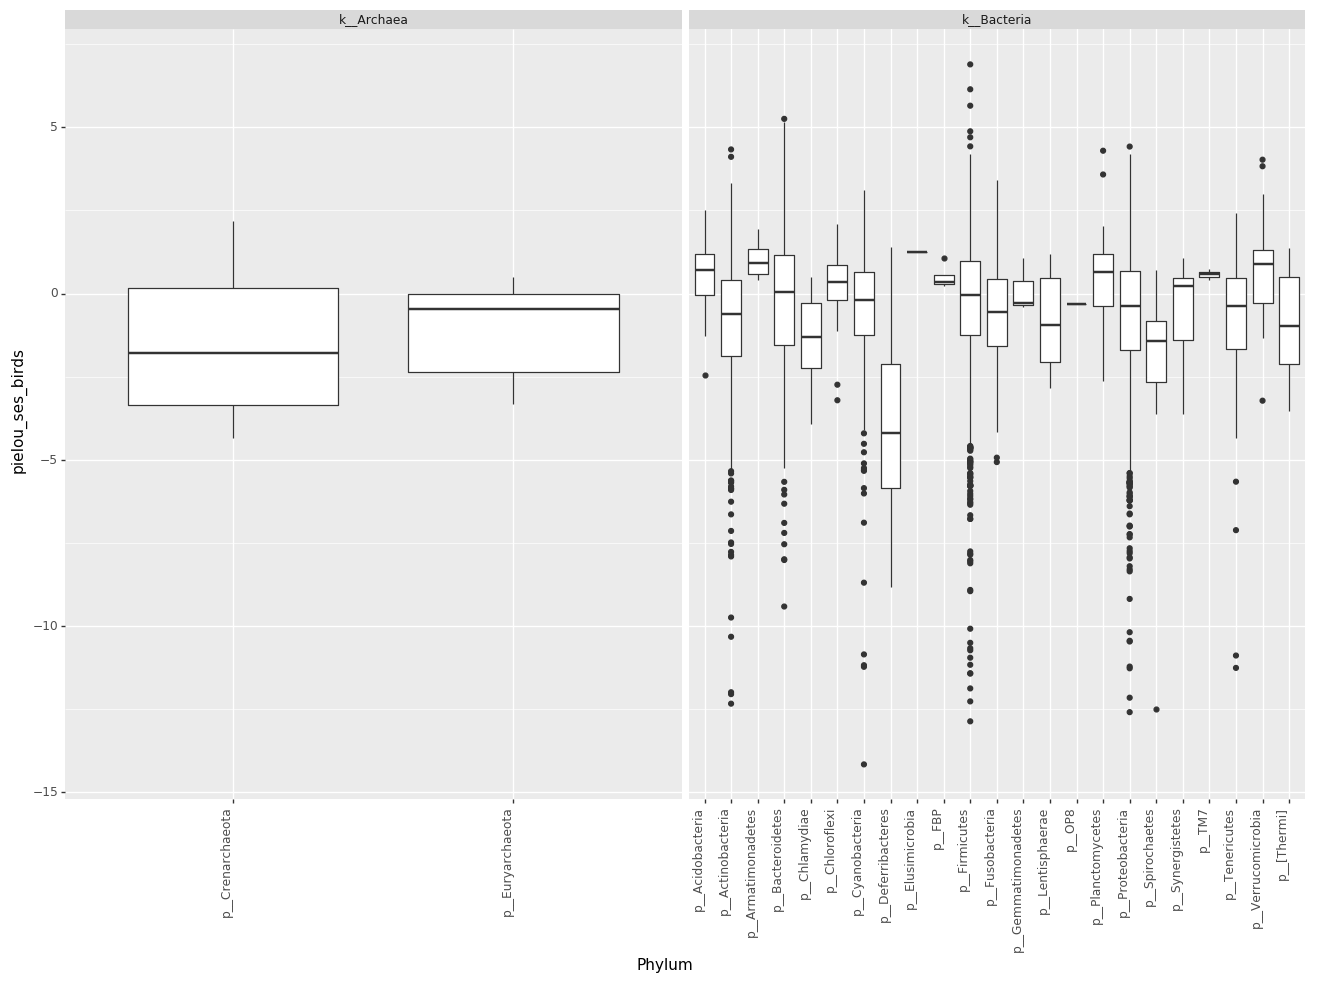

<ggplot: (-9223363300415783957)>

In [66]:
p = (ggplot(tax_ses_bird) +
     geom_boxplot(aes(x = 'Phylum',
                      y = 'pielou_ses_birds')) +
     facet_wrap('~Kingdom', 
                scales='free_x') +
     theme(figure_size=(16, 10), 
           axis_text_x=element_text(rotation=90, hjust=1))
    )

p.save(join(outdir, 'pielou_ses_boxplot.bird-ses.bacteria.phylum.pdf'),
       width=16, height=10)

p

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 16 x 10 in image.
  from_inches(height, units), units))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../specificity_stats/pielou_ses_boxplot.bird-ses.bacteria.class.per-phylum.pdf
  warn('Filename: {}'.format(filename))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is 

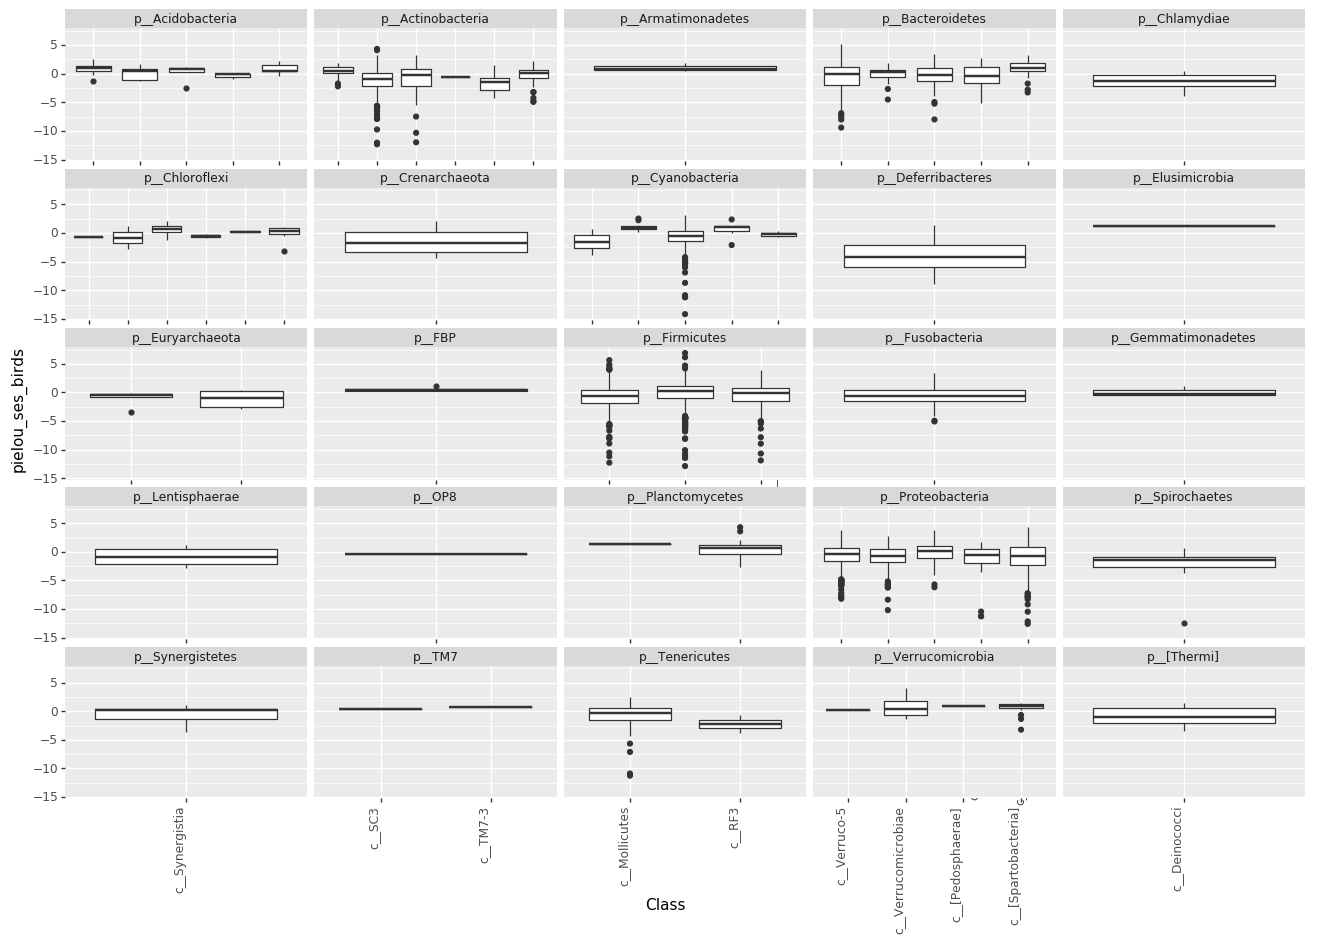

<ggplot: (8736426500293)>

In [67]:
p = (ggplot(tax_ses_bird) +
     geom_boxplot(aes(x = 'Class',
                      y = 'pielou_ses_birds')) +
     facet_wrap('~Phylum', 
                scales='free_x') +
     theme(figure_size=(16, 10), 
           axis_text_x=element_text(rotation=90, hjust=1))
    )

p.save(join(outdir, 'pielou_ses_boxplot.bird-ses.bacteria.class.per-phylum.pdf'),
       width=16, height=10)

p

## Risk ratios

Are ASVs found in bats more likely to be found in birds than ASVs in other mammals?

We'll calculate this using log risk ratios, which is the ratio of prevalence in mammals to the prevalence in birds. So a log10 RR of 0 would indicate an ASV that was found in the same proportion of mammalian samples as bird samples; a log10 RR of 1 would indicate an ASV found 10 times more often in mammal than in bird samples; and a log10 RR of -1 would indicate an ASV found 10 times more often in birds than in mammals. 

In [68]:
class_sample_counts = md.loc[vert_table.ids(axis='sample'), 'Taxonomy_Class'].value_counts()

In [69]:
vert_odds = vert_env/class_sample_counts

In [70]:
vert_risk_ratio = vert_odds['Mammalia'] / vert_odds['Aves']

In [71]:
vert_lrr = vert_risk_ratio.apply(np.log10)

Anything that is never found in birds or never found in mammals will end up with an `Inf` log ratio. So that we can measure these, we'll assign them values at the extremes of the observed distribution (which is, logically, dictated by the number of samples in the dataset, as the minimum observed defined ratio will be (1/Nm) / (Nb/Nb), where Nm is the number of mammalian samples and Nb is the number of bird samples). 

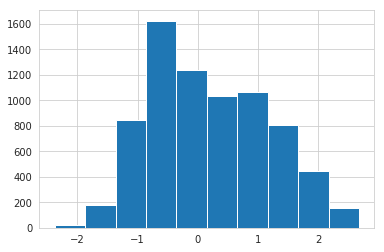

In [72]:
vert_lrr_noinf_nona = vert_lrr.replace([np.inf, -np.inf], np.nan).dropna()
vert_lrr_noinf_nona.hist()

Here, that works out to be about +/- 3, or about 1000:1 ratio of prevalence. 

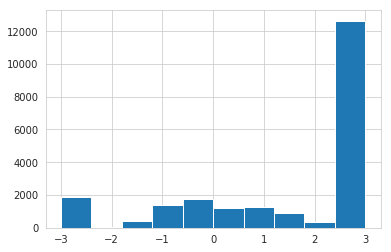

In [73]:
vert_lrr_nona = vert_lrr.replace([np.inf], 3).replace([-np.inf], -3).dropna()
vert_lrr_nona.hist()

### Get averages

We'll calculate averages using the same method we used for Pielou SES, with the mean RR of each ASV in a sample and the abundance-weighetd mean RR of each ASV.

In [74]:
vert_rr_df = get_asv_ses_avgs(vert_lrr_nona, vert_table)

In [75]:
vert_rr_df.columns = ['mammal:bird_RR_%s' % x for x in vert_rr_df.columns]

In [126]:
md_vert_rr = pd.concat([md, vert_rr_df],
                       axis=1)

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [128]:
md_vert_rr = md_vert_rr[['Taxonomy_Order','Taxonomy_Class','Taxonomy_Family','Taxonomy_Genus',
                         'flight_status',
                         'mammal:bird_RR_mean', 'mammal:bird_RR_weighted_mean']]

In [129]:
# create sorted factor 
order_list = md_vert_rr[['Taxonomy_Order',
                         'mammal:bird_RR_mean']].groupby('Taxonomy_Order').median().dropna().sort_values('mammal:bird_RR_mean').index.tolist()

order_cat = CategoricalDtype(categories=order_list, ordered=True)

md_vert_rr['Taxonomy_Order_mean_sorted'] = md_vert_rr['Taxonomy_Order'].astype(str).astype(order_cat)

In [132]:
md_vert_rr_melt = pd.melt(md_vert_rr, 
                         id_vars = ['Taxonomy_Order','Taxonomy_Class','Taxonomy_Family','Taxonomy_Genus',
                                    'Taxonomy_Order_mean_sorted', 'flight_status'])
md_vert_rr_melt = md_vert_rr_melt.dropna()

### Plots


#### Boxplot: birds and mammals

These boxplots show the distributions of mean log10 Risk Ratio among birds and mammals.

In [80]:
outdir = '../specificity_stats/risk_ratios'
makedirs(outdir, exist_ok=True)

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 16 x 16 in image.
  from_inches(height, units), units))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../specificity_stats/risk_ratios/mam_bird_riskratio_boxplot.birds.mammals.pdf
  warn('Filename: {}'.format(filename))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is n

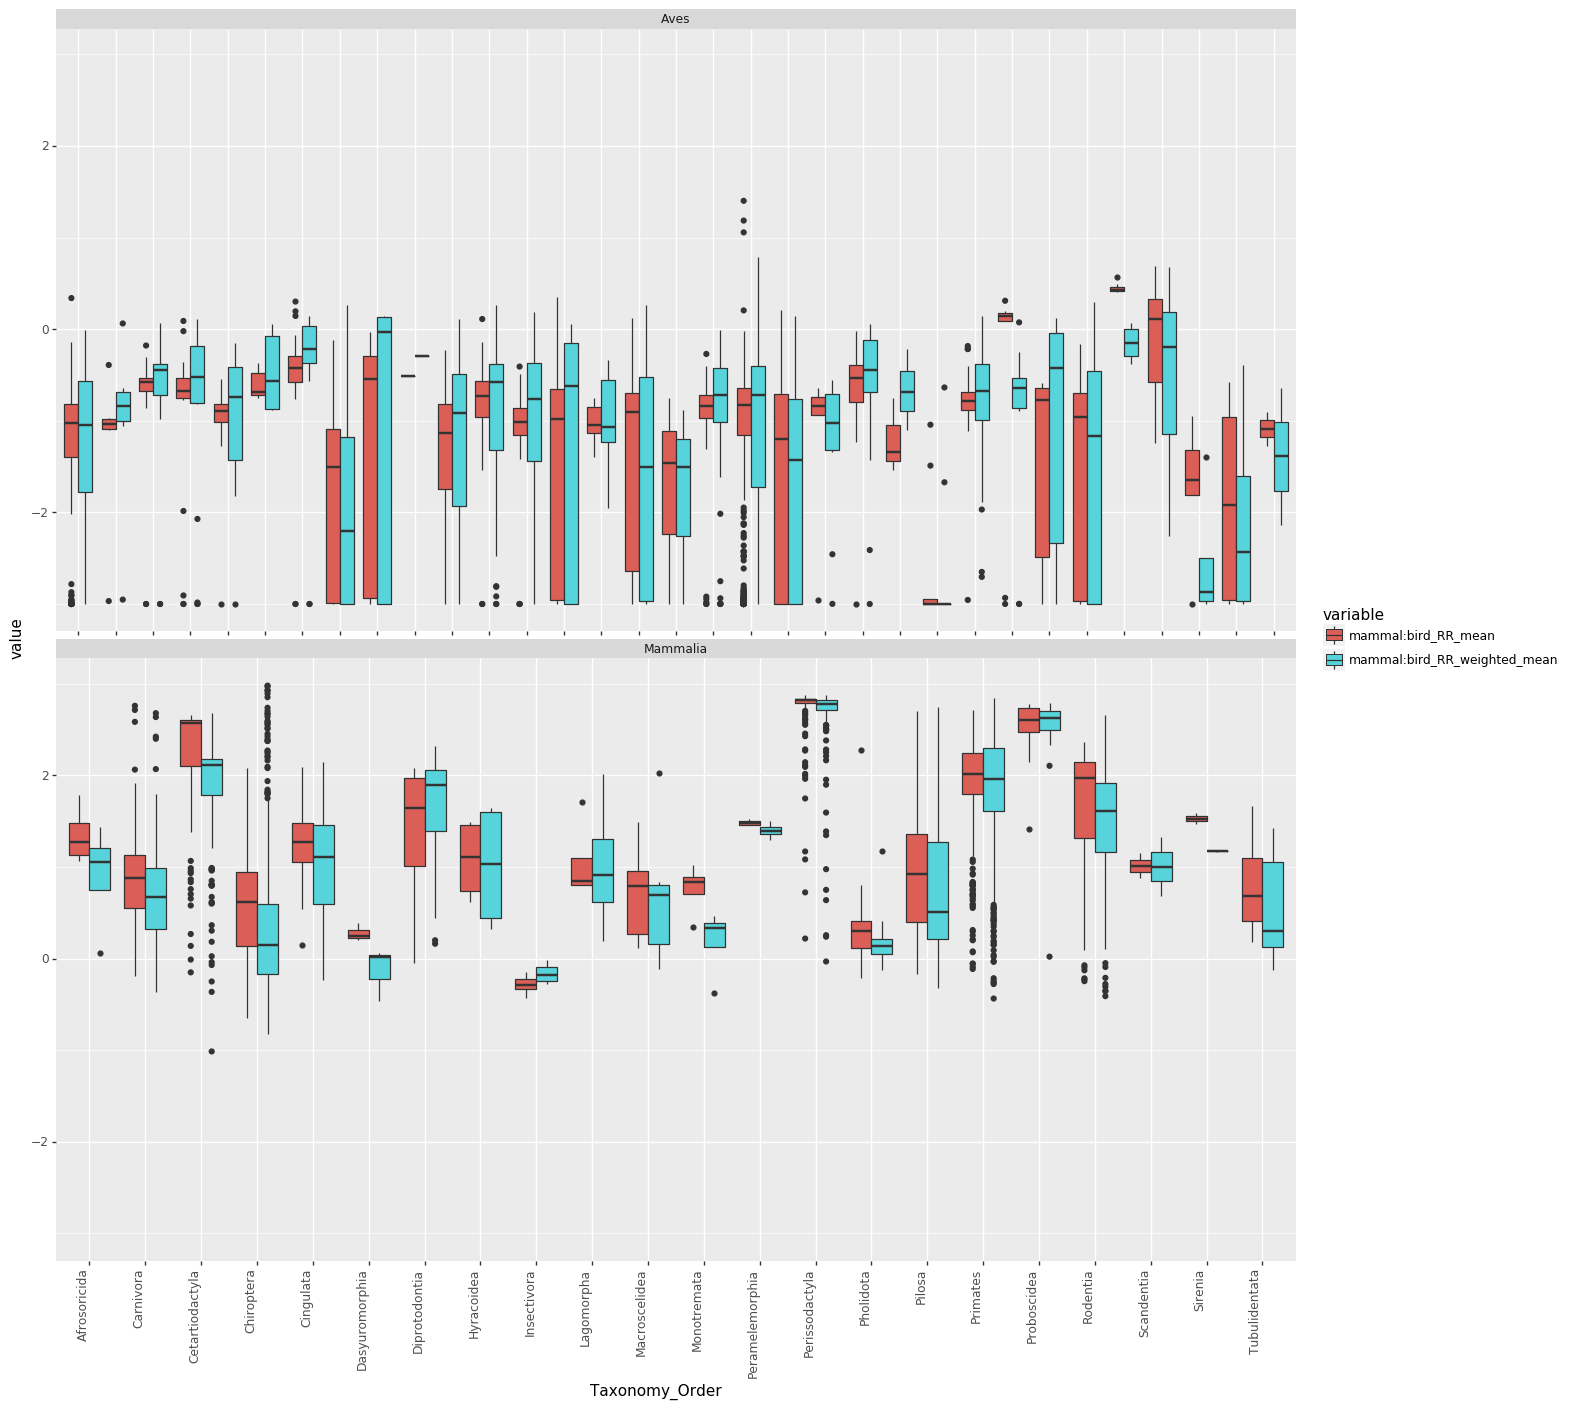

<ggplot: (8736442744079)>

In [81]:
p = (ggplot(md_vert_rr_melt.loc[md_vert_rr_melt['Taxonomy_Class'].isin(['Mammalia',
                                                                        'Aves'])],) +
        geom_boxplot(aes(x = 'Taxonomy_Order', 
                         y = 'value',
                         fill = 'variable')) +
        facet_wrap('~Taxonomy_Class',
                   scales='free_x',
                   ncol=1) +
        theme(figure_size=(16, 16), 
              axis_text_x=element_text(rotation=90, hjust=1)))

p.save(join(outdir, 'mam_bird_riskratio_boxplot.birds.mammals.pdf'),
       width=16, height=16)

p

It's clear that the insectivores and bats are on the extreme on the mammal scale, but it might be easier to parse if we order the host categories by median per-sample mean log RR.

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 12 x 12 in image.
  from_inches(height, units), units))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../specificity_stats/risk_ratios/mam_bird_riskratio_boxplot.mammals.birds.sorted.pdf
  warn('Filename: {}'.format(filename))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenati

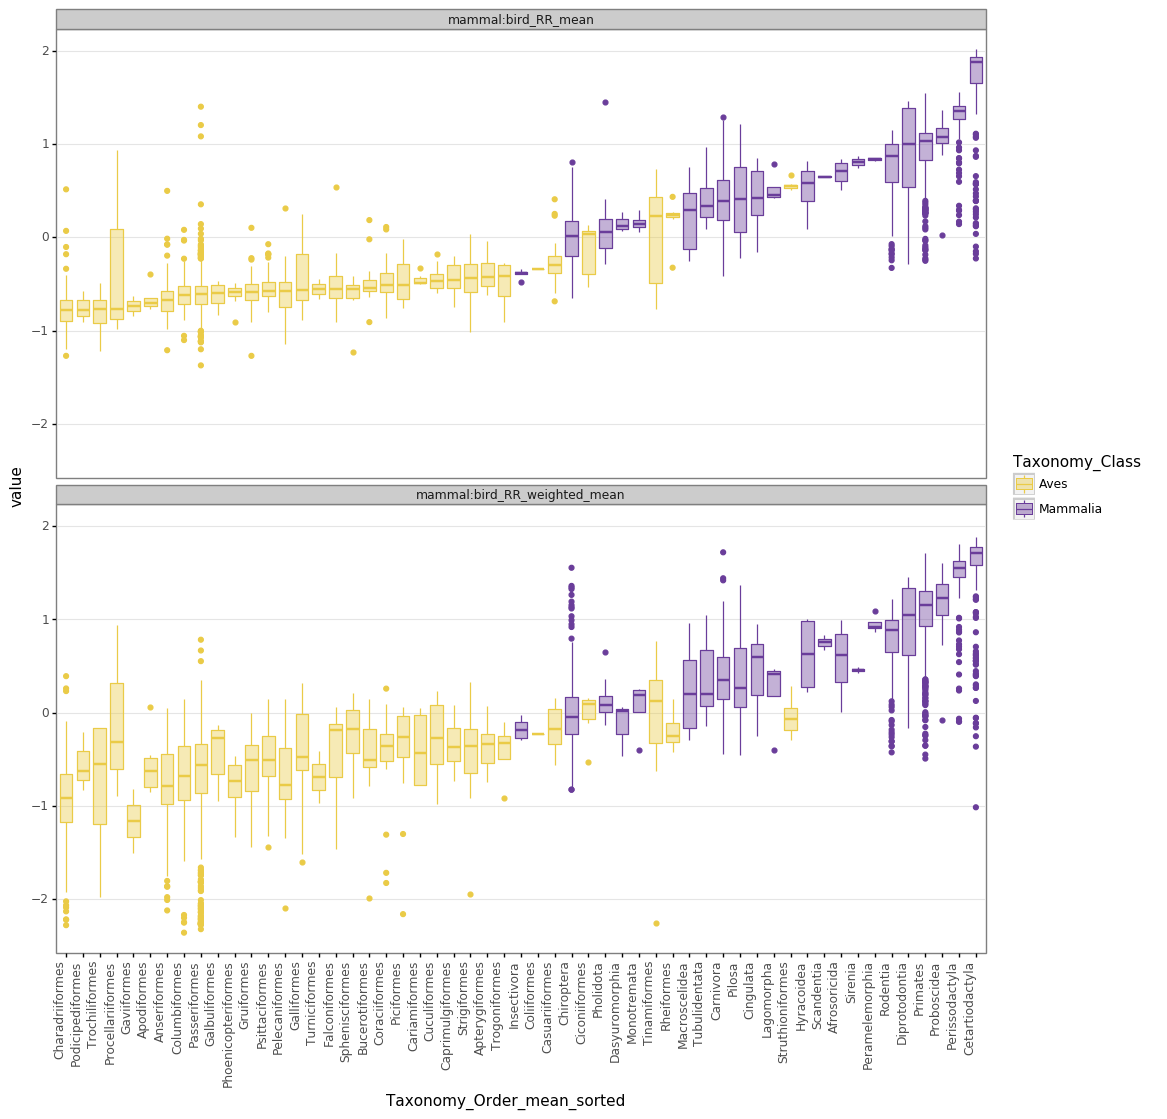

<ggplot: (-9223363300426811192)>

In [115]:
p = (ggplot(md_vert_rr_melt.loc[md_vert_rr_melt['Taxonomy_Class'].isin(['Mammalia',
                                                                        'Aves'])]) +
        geom_boxplot(aes(x = 'Taxonomy_Order_mean_sorted', 
                         y = 'value',
                         fill = 'Taxonomy_Class',
                         color = 'Taxonomy_Class'),
                     alpha=0.4) +
        facet_wrap('~variable',
                   ncol=1) +
        scale_fill_manual(values=class_colors) +
        scale_color_manual(values=class_colors) +
        theme_bw() +
        theme(figure_size=(12, 12), 
              axis_text_x=element_text(rotation=90, hjust=1),
              panel_grid_major_x = element_blank(),
              panel_grid_minor = element_blank()))

p.save(join(outdir, 'mam_bird_riskratio_boxplot.mammals.birds.sorted.pdf'),
       width=12, height=12)

p

Here it becomes obvious that the insectivores + bats have the most birdlike RR, while the rheiformes, struthioformes, and tinamiformes have the most mammal-like RR. For the latter, this is only the case when considering the raw mean scores, and not the abundance-weighted scores, indicating that the ASVs that are comparatively more likely to be found in mammals are relatively rare in these bird orders.

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 9 x 5 in image.
  from_inches(height, units), units))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../specificity_stats/risk_ratios/mam_bird_riskratio_boxplot.mammals.birds.sorted.mean.pdf
  warn('Filename: {}'.format(filename))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concaten

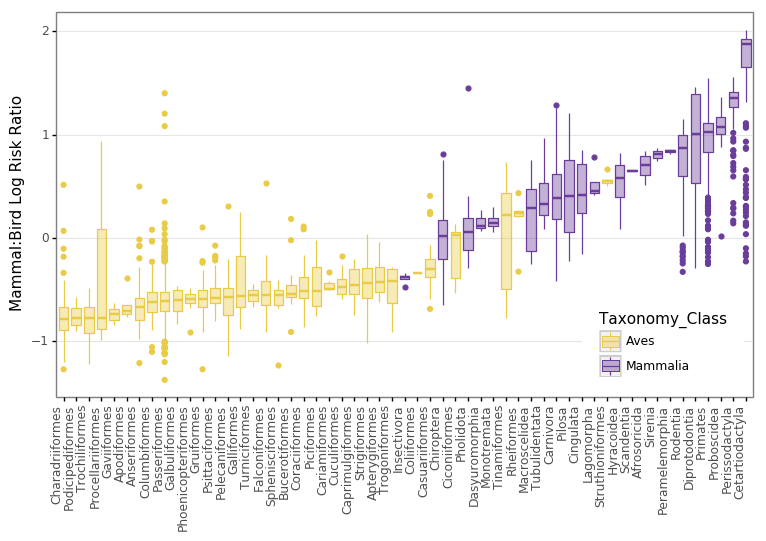

<ggplot: (8736426446442)>

In [151]:
p = (ggplot(md_vert_rr_melt.loc[(md_vert_rr_melt['Taxonomy_Class'].isin(['Mammalia',
                                                                        'Aves'])) &
                                (md_vert_rr_melt['variable'] == 'mammal:bird_RR_mean')]) +
        geom_boxplot(aes(x = 'Taxonomy_Order_mean_sorted', 
                         y = 'value',
                         fill = 'Taxonomy_Class',
                         color = 'Taxonomy_Class'),
                    alpha=0.4) +
        scale_fill_manual(values=class_colors) +
        scale_color_manual(values=class_colors) +
        ylab('Mammal:Bird Log Risk Ratio') +
        theme_bw() +
        theme(figure_size=(9, 5), 
              axis_text_x=element_text(rotation=90, hjust=1),
              panel_grid_major_x = element_blank(),
              panel_grid_minor = element_blank(),
              axis_title_x = element_blank(),
              legend_position = (0.8,0.22 )))

p.save(join(outdir, 'mam_bird_riskratio_boxplot.mammals.birds.sorted.mean.pdf'),
       width=9, height=5)

p

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 3 x 2 in image.
  from_inches(height, units), units))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../specificity_stats/risk_ratios/mam_bird_riskratio_boxplot.mammals.birds.flight.inset.pdf
  warn('Filename: {}'.format(filename))


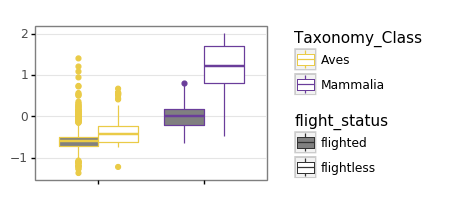

<ggplot: (8736451828067)>

In [147]:
p = (ggplot(md_vert_rr_melt.loc[(md_vert_rr_melt['Taxonomy_Class'].isin(['Mammalia',
                                                                        'Aves'])) &
                                (md_vert_rr_melt['variable'] == 'mammal:bird_RR_mean')]) +
        geom_boxplot(aes(x = 'Taxonomy_Class', 
                         y = 'value',
                         fill = 'flight_status',
                         color = 'Taxonomy_Class'),
                    alpha=1) +
        scale_color_manual(values=class_colors) +
        scale_fill_manual(values={'flighted': 'grey',
                                   'flightless': 'white'}) +
        theme_bw() +
        theme(figure_size=(3, 1.5),
              axis_text_x = element_blank(),
              panel_grid_major_x = element_blank(),
              panel_grid_minor = element_blank(),
              axis_title_x = element_blank(),
              axis_title_y = element_blank()))

p.save(join(outdir, 'mam_bird_riskratio_boxplot.mammals.birds.flight.inset.pdf'),
       width=3, height=2)

p

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 16 x 10 in image.
  from_inches(height, units), units))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../specificity_stats/risk_ratios/mam_bird_riskratio_boxplot.mammals.birds.sorted.weighted_mean.pdf
  warn('Filename: {}'.format(filename))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because n

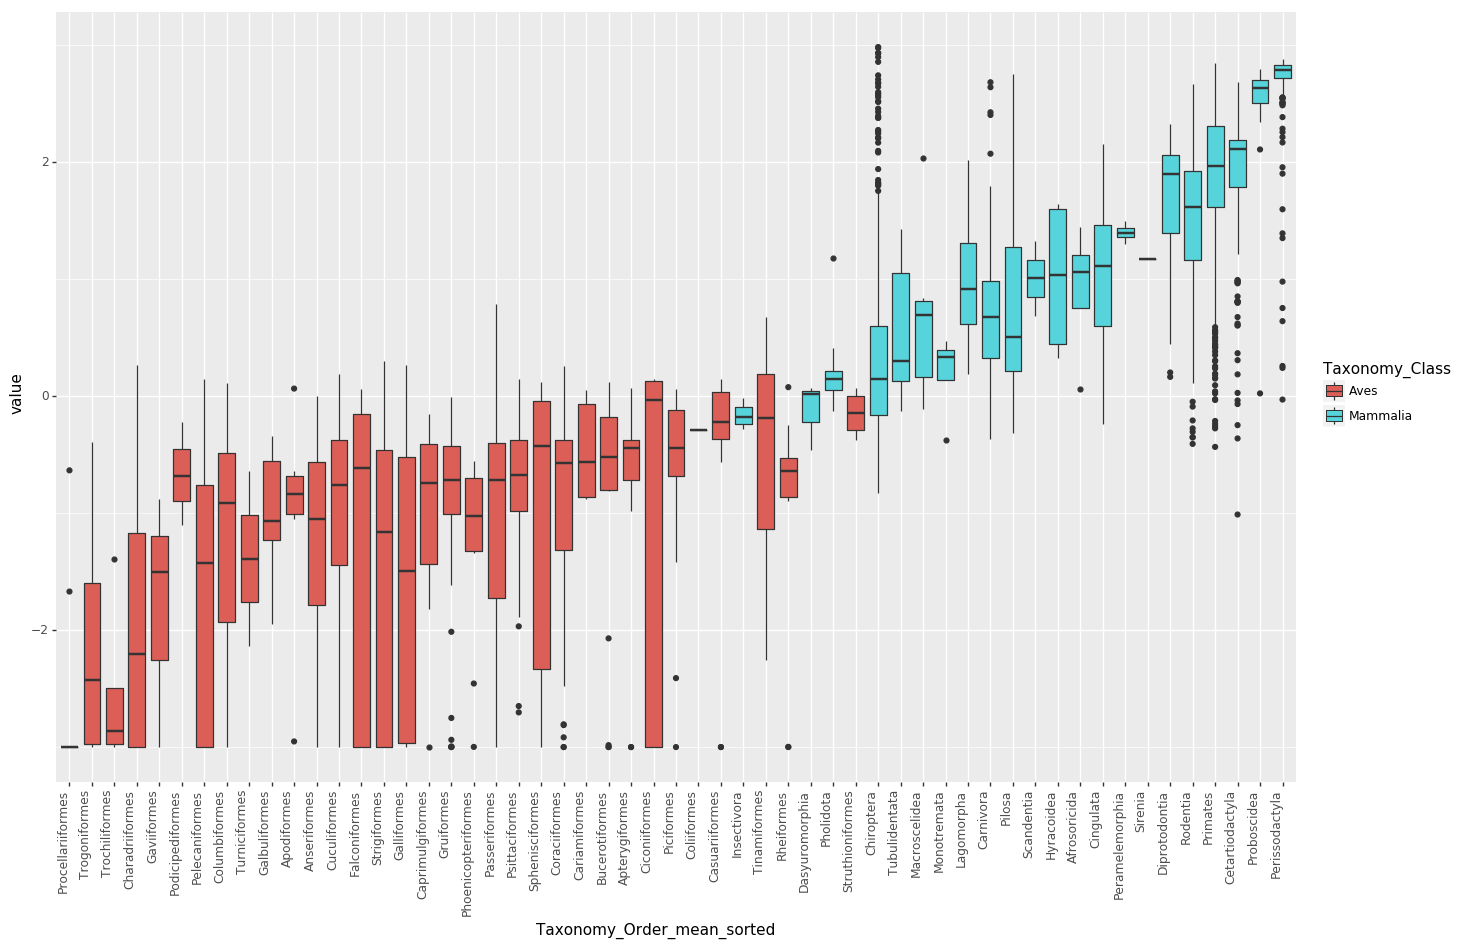

<ggplot: (8736428276414)>

In [84]:
p = (ggplot(md_vert_rr_melt.loc[(md_vert_rr_melt['Taxonomy_Class'].isin(['Mammalia',
                                                                        'Aves'])) &
                                (md_vert_rr_melt['variable'] == 'mammal:bird_RR_weighted_mean')]) +
        geom_boxplot(aes(x = 'Taxonomy_Order_mean_sorted', 
                         y = 'value',
                         fill = 'Taxonomy_Class')) +
        theme(figure_size=(16, 10), 
              
              axis_text_x=element_text(rotation=90, hjust=1)))

p.save(join(outdir, 'mam_bird_riskratio_boxplot.mammals.birds.sorted.weighted_mean.pdf'),
       width=16, height=10)

p

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 16 x 16 in image.
  from_inches(height, units), units))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../specificity_stats/risk_ratios/mam_bird_riskratio_boxplot.mammals.pdf
  warn('Filename: {}'.format(filename))


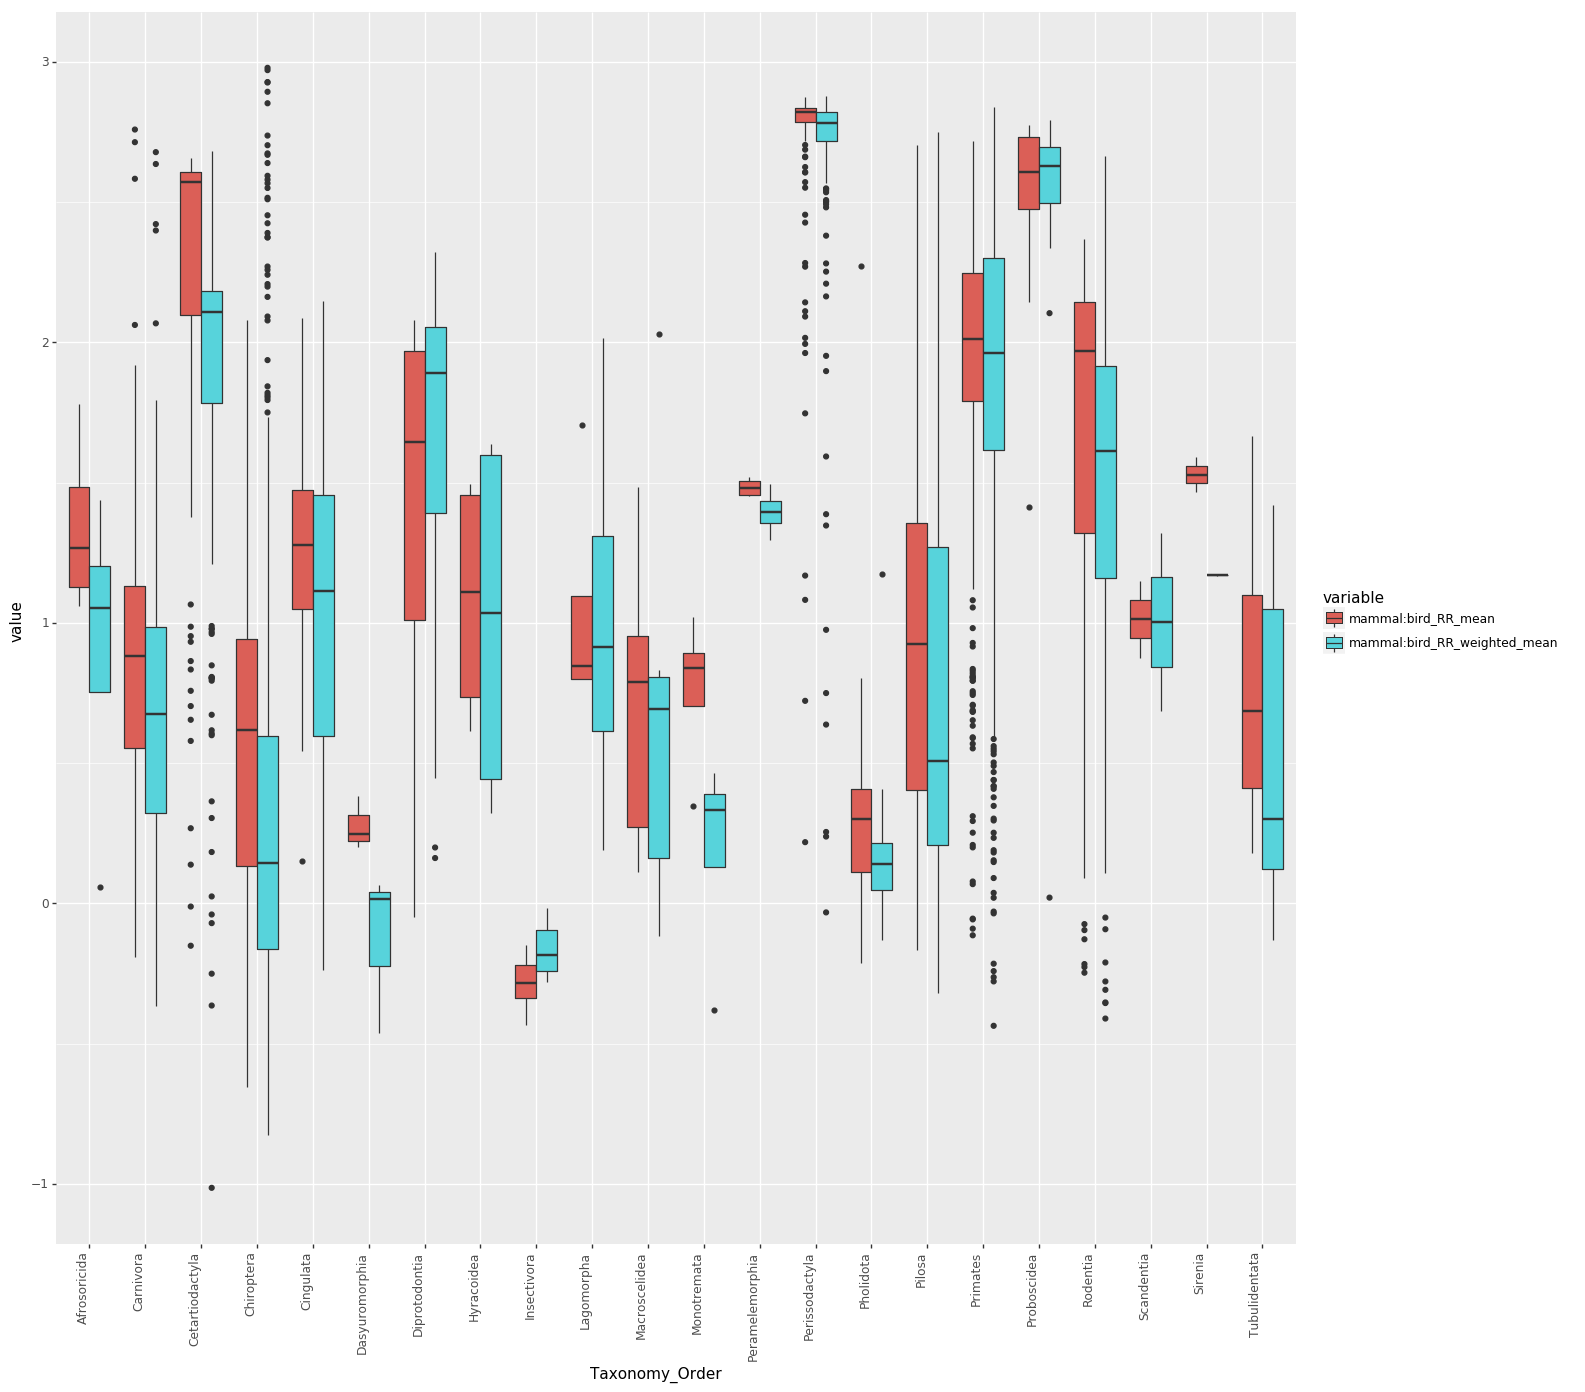

<ggplot: (-9223363300417426144)>

In [85]:
p = (ggplot(md_vert_rr_melt.loc[md_vert_rr_melt['Taxonomy_Class'].isin(['Mammalia'])],) +
        geom_boxplot(aes(x = 'Taxonomy_Order', 
                         y = 'value',
                         fill = 'variable')) +
#         facet_wrap('~Taxonomy_Class',
#                    scales='free_x',
#                    ncol=1) +
        theme(figure_size=(16, 16), 
              axis_text_x=element_text(rotation=90, hjust=1)))

p.save(join(outdir, 'mam_bird_riskratio_boxplot.mammals.pdf'),
       width=16, height=16)

p

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 16 x 16 in image.
  from_inches(height, units), units))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../specificity_stats/risk_ratios/mam_bird_riskratio_boxplot.birds.pdf
  warn('Filename: {}'.format(filename))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not 

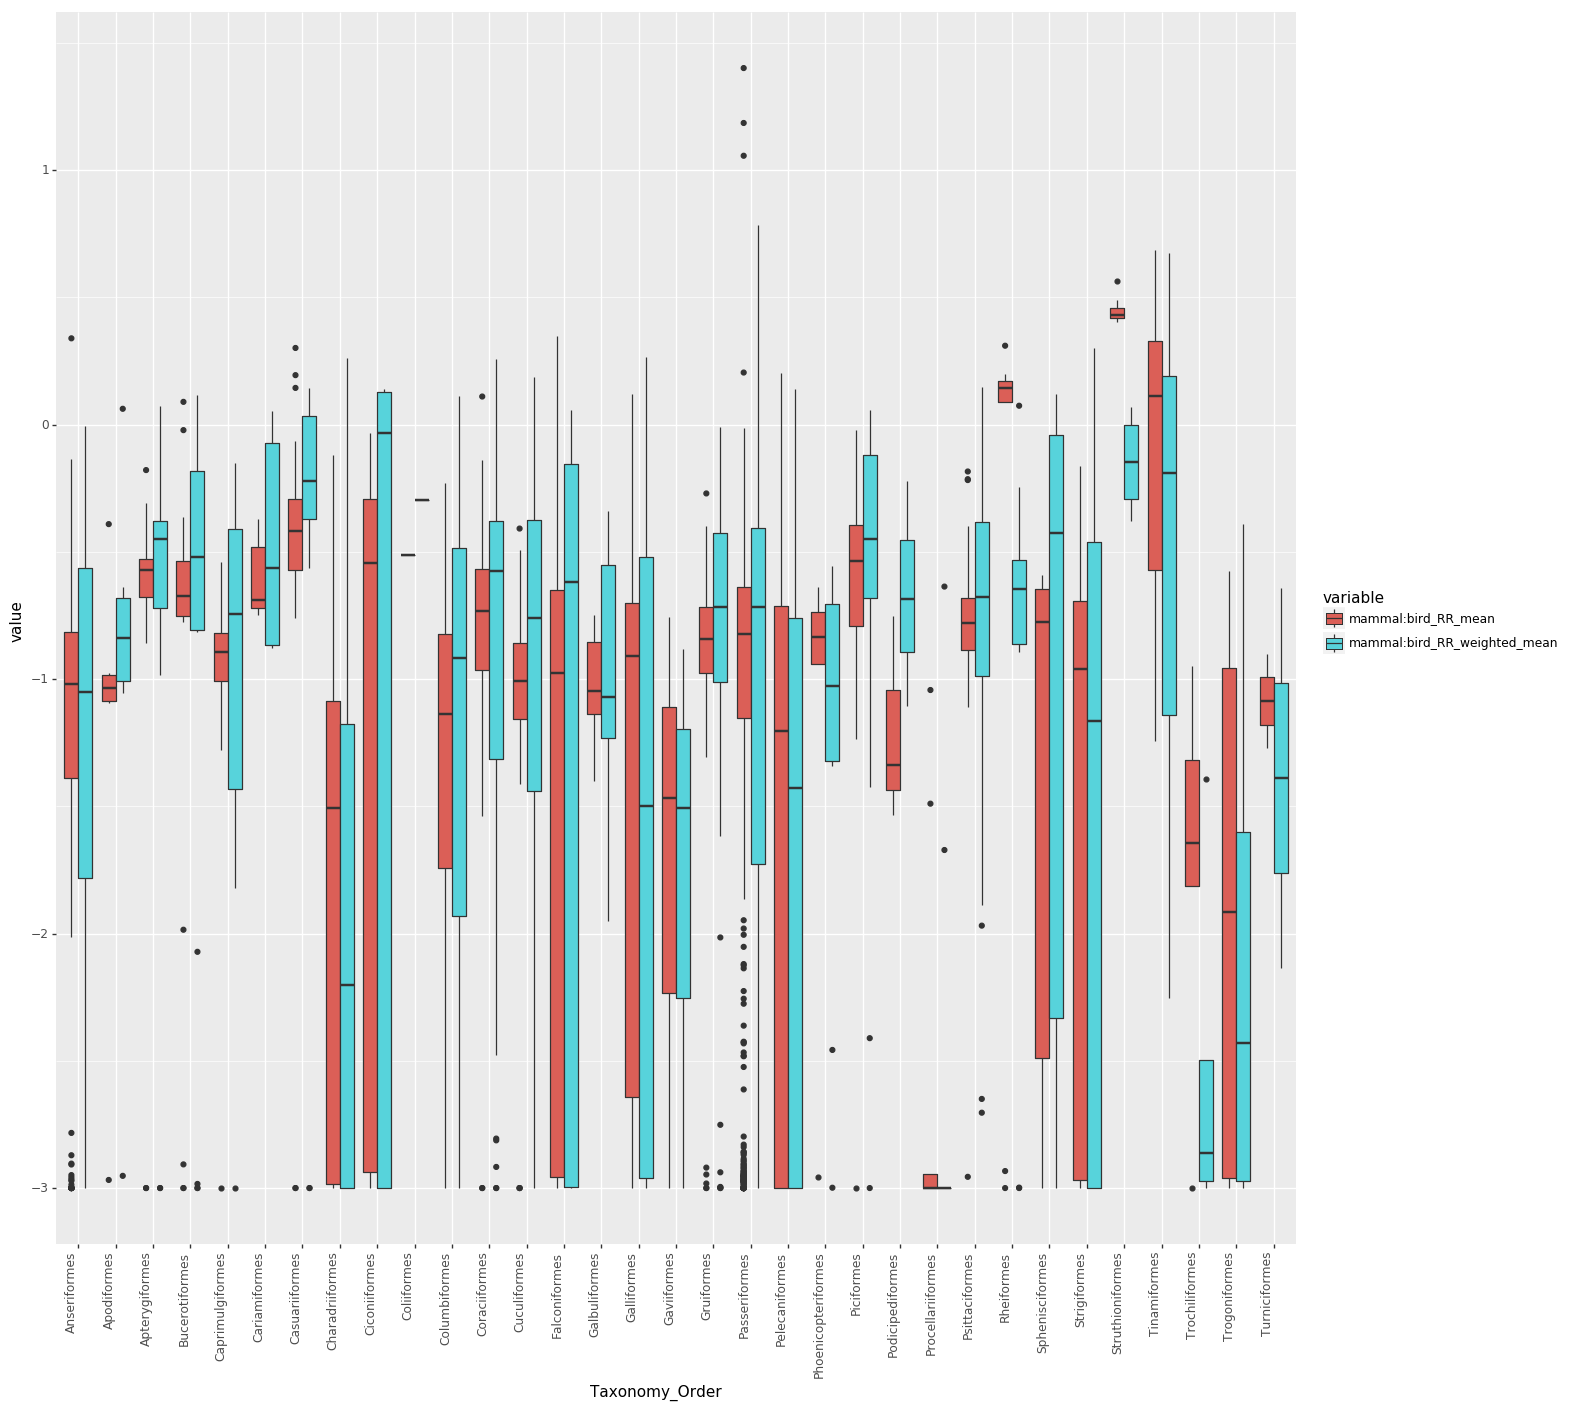

<ggplot: (-9223363300421219612)>

In [86]:
p = (ggplot(md_vert_rr_melt.loc[md_vert_rr_melt['Taxonomy_Class'].isin(['Aves'])],) +
        geom_boxplot(aes(x = 'Taxonomy_Order', 
                         y = 'value',
                         fill = 'variable')) +
#         facet_wrap('~Taxonomy_Class',
#                    scales='free_x',
#                    ncol=1) +
        theme(figure_size=(16, 16), 
              axis_text_x=element_text(rotation=90, hjust=1)))

p.save(join(outdir, 'mam_bird_riskratio_boxplot.birds.pdf'),
       width=16, height=16)

p

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 16 x 10 in image.
  from_inches(height, units), units))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../specificity_stats/risk_ratios/mam_bird_riskratio_boxplot.bats.pdf
  warn('Filename: {}'.format(filename))
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not a

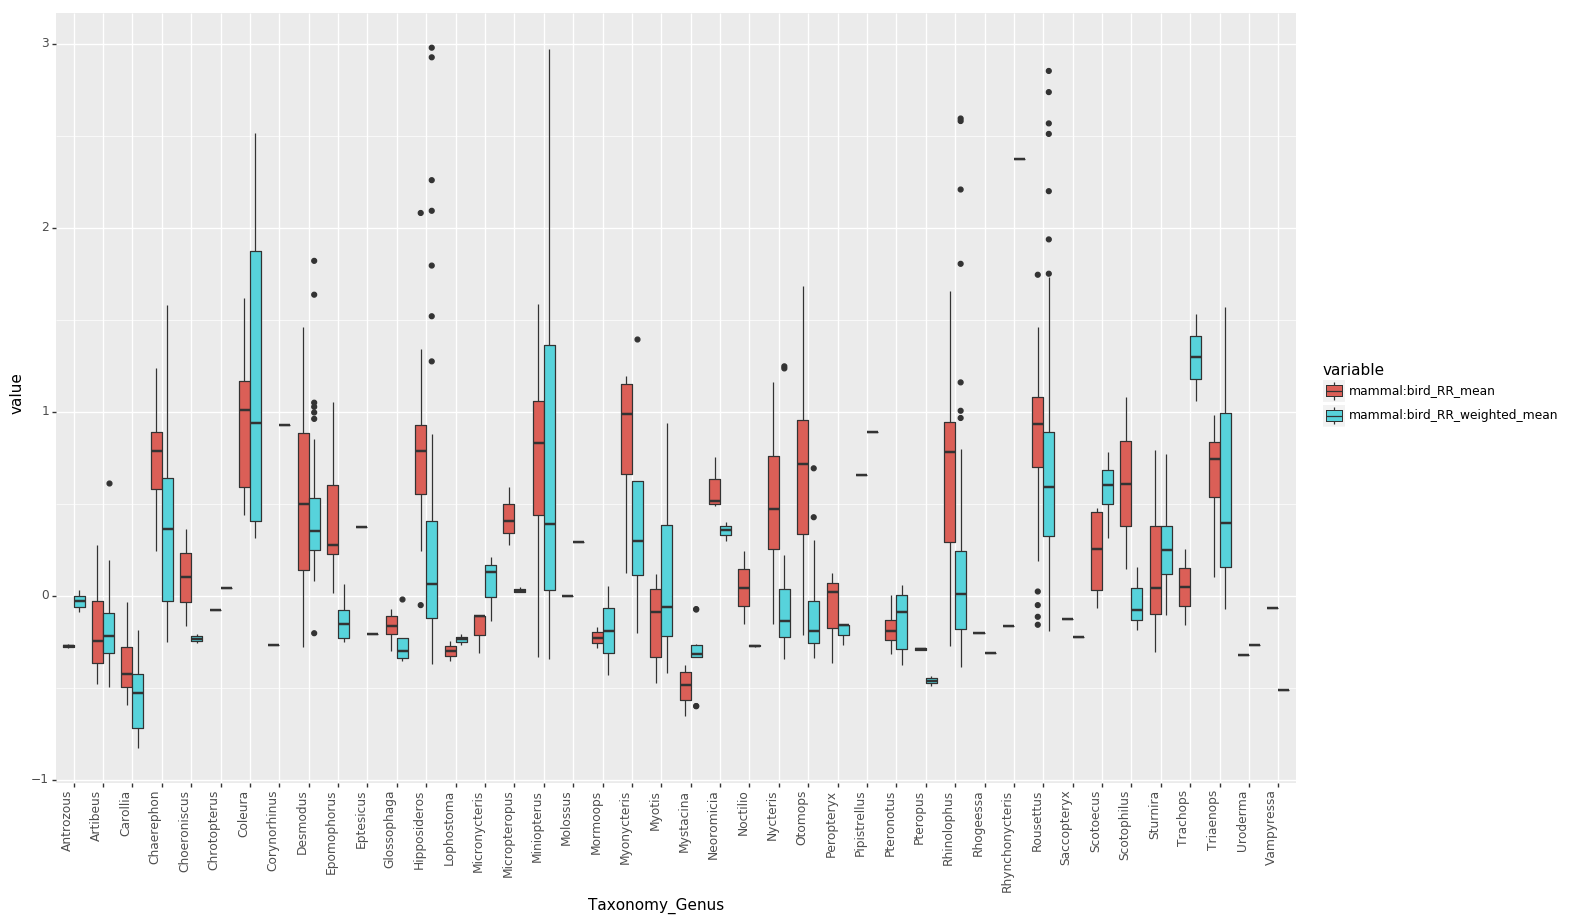

<ggplot: (-9223363300426500797)>

In [87]:
p = (ggplot(md_vert_rr_melt.loc[md_vert_rr_melt['Taxonomy_Order'] == 'Chiroptera'],) +
     geom_boxplot(aes(x = 'Taxonomy_Genus', 
                      y = 'value',
                      fill = 'variable')) +
    #  facet_wrap('~Taxonomy_Class',
    #             scales='free_x',
    #             ncol=1) +
     theme(figure_size=(16, 10), 
           axis_text_x=element_text(rotation=90, hjust=1)))

p.save(join(outdir, 'mam_bird_riskratio_boxplot.bats.pdf'),
       width=16, height=10)

p

### Get averages for only shared ASVs

What does it look like if we exclude the strictly specific ASVs, and only include things that were found at least once among mammals and birds?

In [88]:
vert_rr_df = get_asv_ses_avgs(vert_lrr_noinf_nona, vert_table)

In [89]:
vert_rr_df.columns = ['mammal:bird_RR_%s' % x for x in vert_rr_df.columns]

In [90]:
md_vert_rr = pd.concat([md, vert_rr_df],
                       axis=1)

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [91]:
md_vert_rr = md_vert_rr[['Taxonomy_Order','Taxonomy_Class','Taxonomy_Family','Taxonomy_Genus',
                         'mammal:bird_RR_mean', 'mammal:bird_RR_weighted_mean']]

In [92]:
# create sorted factor 
order_list = md_vert_rr[['Taxonomy_Order',
                         'mammal:bird_RR_mean']].groupby('Taxonomy_Order').median().dropna().sort_values('mammal:bird_RR_mean').index.tolist()

order_cat = CategoricalDtype(categories=order_list, ordered=True)

md_vert_rr['Taxonomy_Order_mean_sorted'] = md_vert_rr['Taxonomy_Order'].astype(str).astype(order_cat)

In [93]:
md_vert_rr_melt = pd.melt(md_vert_rr, 
                         id_vars = ['Taxonomy_Order','Taxonomy_Class','Taxonomy_Family','Taxonomy_Genus',
                                    'Taxonomy_Order_mean_sorted'])
md_vert_rr_melt = md_vert_rr_melt.dropna()

/home/jgsanders/.conda/envs/jupyter-qiime2-2019.1/lib/python3.6/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)


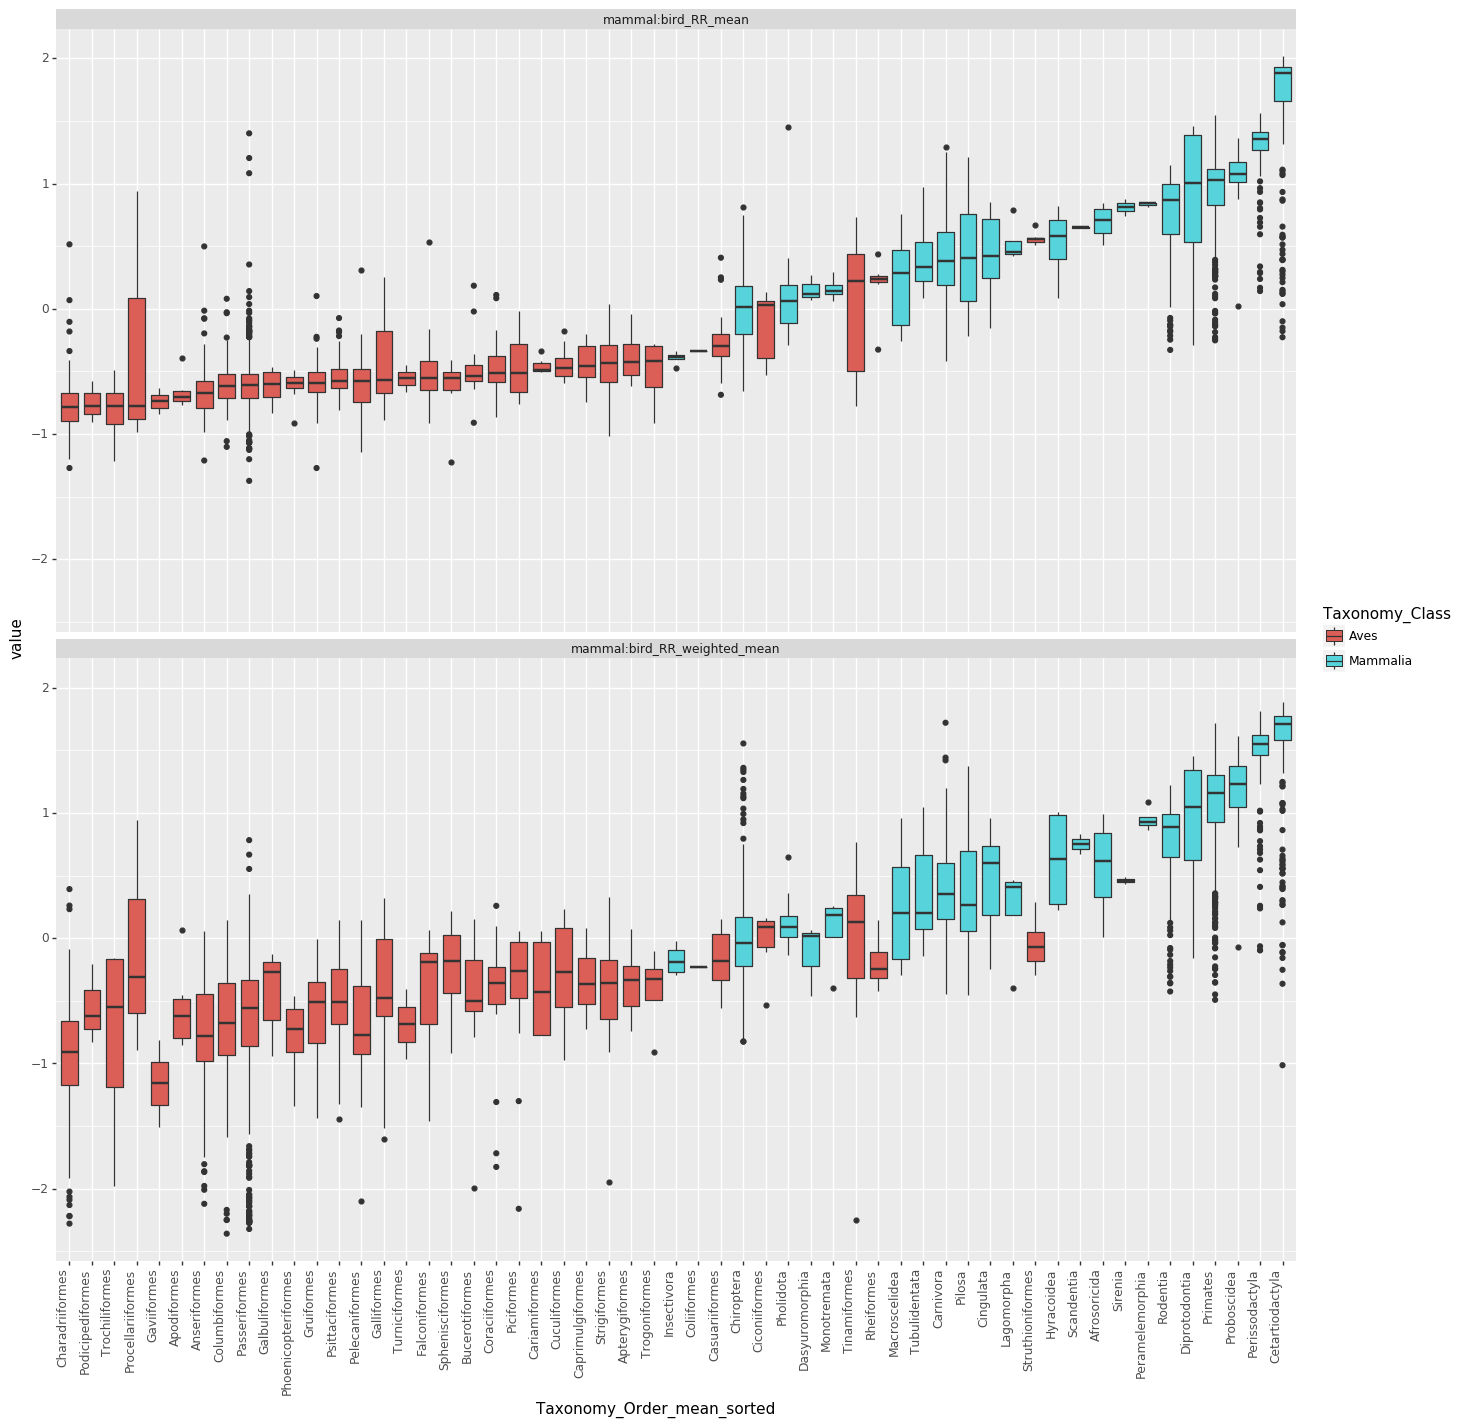

<ggplot: (-9223363300398069020)>

In [94]:
p = (ggplot(md_vert_rr_melt.loc[md_vert_rr_melt['Taxonomy_Class'].isin(['Mammalia',
                                                                        'Aves'])]) +
        geom_boxplot(aes(x = 'Taxonomy_Order_mean_sorted', 
                         y = 'value',
                         fill = 'Taxonomy_Class')) +
        facet_wrap('~variable',
                   ncol=1) +
        theme(figure_size=(16, 16), 
              axis_text_x=element_text(rotation=90, hjust=1)))

# p.save(join(outdir, 'mam_bird_riskratio_boxplot.mammals.birds.sorted.pdf'),
#        width=16, height=16)

p

The rank-ordering is pretty similar, with bats hosting among the most birdlike communities, and the ratites moving quite a bit up into mammal territory. 